# Main

In [1]:
"""Scripts for analyzing of phantom outputs.

This script analyze the json files written from the main frame
and produce a plot.


-------------------------------------------------------------------------------

Side note: Remember to limit line length to 79 characters according to PEP-8
    https://peps.python.org/pep-0008/#maximum-line-length    
which is the length of below line of '-' characters.

-------------------------------------------------------------------------------

"""

"Scripts for analyzing of phantom outputs.\n\nThis script analyze the json files written from the main frame\nand produce a plot.\n\n\n-------------------------------------------------------------------------------\n\nSide note: Remember to limit line length to 79 characters according to PEP-8\n    https://peps.python.org/pep-0008/#maximum-line-length    \nwhich is the length of below line of '-' characters.\n\n-------------------------------------------------------------------------------\n\n"

## Imports & Settings

In [2]:
#%matplotlib inline
import math
import numpy as np
from numpy import pi
#import pandas
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib as mpl
from moviepy.editor import ImageSequenceClip
from os import path

In [3]:
# import modules listed in ./lib/

import clmuphantomlib as mupl
from clmuphantomlib.readwrite import json_load
from clmuphantomlib.units_util import set_as_quantity, get_val_in_unit, get_units_field_name, get_units_cgs

    ## import modules in arbitrary directory
    
    #import sys
    
    ## path to my python module lib directory
    ## *** CHECK THIS! *** #
    #SRC_LIB_PATH = sys.path[0] + '/lib'
    
    #if SRC_LIB_PATH not in sys.path:
    #    sys.path.append(SRC_LIB_PATH)
    ##print(*sys.path, sep='\n')    # debug
    #print(
    #    "\n*   Please Make sure my module files are located in this directory (or change the SRC_LIB_PATH variable):",
    #    f"\n{SRC_LIB_PATH = }\n"
    #)

    # parallels & optimizations
    
    
    #import os
    ## Fixing stupid numba killing kernel
    ## See here https://github.com/numba/numba/issues/3016
    #os.environ['NUMBA_DISABLE_INTEL_SVML']  = '1'
    #from numba import njit, prange
    
    
    from multiprocessing import cpu_count, Process, Queue
    
    NPROCESSES = cpu_count()
    if NPROCESSES is None:
        NPROCESSES = 1
    NPROCESSES = max(NPROCESSES, 1)


In [4]:
# settings
#
#   imported from script_input.py file


from script_PhLocProfile__input import verbose, output_dir, interm_dir, unitsIn, unitsOut, PHOTOSPHERE_TAU, JOB_PROFILES, JOB_PROFILES_DICT

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }


plt.rcParams.update({'font.size': 20})


# print debug info
if verbose >= 2:
    #print(f"   Note: Will use {NPROCESSES} processes for parallelization")
    pass
    

In [5]:
do_debug = False
if __name__ == '__main__':
    from script_PhLocAxes__input import JOB_PROFILES
    if do_debug:
        JOB_PROFILES_COPY = JOB_PROFILES
        JOB_PROFILES = [job_profile.copy() for job_profile in JOB_PROFILES_COPY[2:]]
        #for job_profile in JOB_PROFILES:
        #    job_profile['file_indexes'] = [job_profile['file_indexes'][-1]]

In [6]:
def get_yval_yerr(
    xval, xerrp, xerrm, xvals, yvals,
) -> (float, float, float):
    """Get y value, error (+), error (-) by interpolating y(x) at x_val."""
    #yval, yerrp, yerrm = get_yval_yerr(xval, xerrp, xerrm, xvals, yvals)
    yval, yerrp_tmp, yerrm_tmp = np.interp((xval, xerrp, xerrm), xvals[::-1], yvals[::-1])
    yerrs = yvals[(xerrm < xvals) & (xvals < xerrp) & np.isfinite(yvals)]
    if len(yerrs) >= 1:
        yerrs = [np.max(yerrs), np.min(yerrs)]
    else:
        yerrs = []
    if not np.isfinite(yerrp_tmp):
        yerrs.append(yerrp_tmp)
    if not np.isfinite(yerrm_tmp):
        yerrs.append(yerrm_tmp)
    if len(yerrs) >= 2:
        yerrp, yerrm = np.max(yerrs), np.min(yerrs)
    else:
        yerrp, yerrm = np.nan, np.nan
    return yval, yerrp, yerrm

# Analysis

## Photosphere size vs time

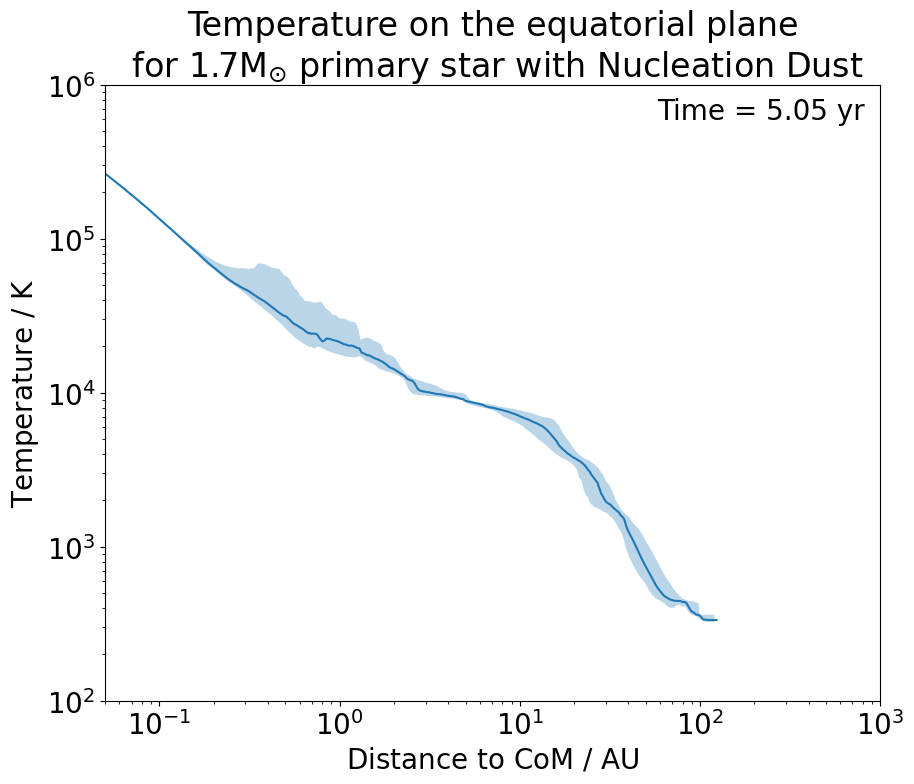

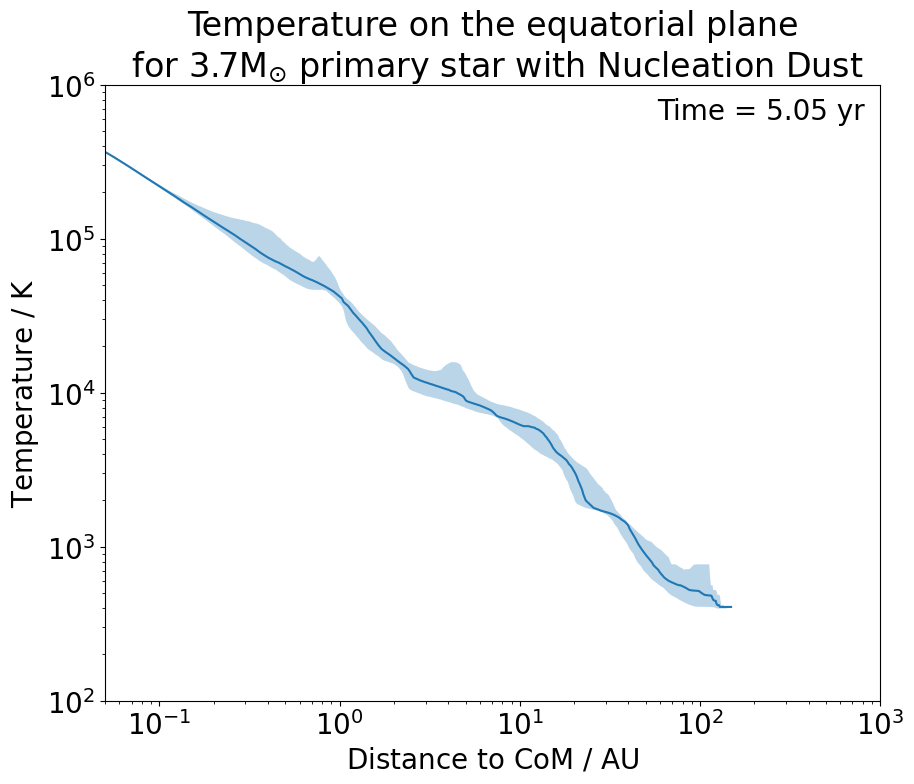

In [30]:
if __name__ == '__main__':

    # plotting

    xlim = (0.05, 1e3)
    ylim = (1e2, 1e6)
    quan = 'T'
    quan_name = 'Temperature'

    
    file_indexes = [2000]

    
    for job_profile in JOB_PROFILES[:2]:
        job_name = job_profile['job_name']

        for file_index in file_indexes:
            

            fig, ax = plt.subplots(figsize=(10, 8))
    
            with open(f"{mupl.get_filename_phantom_dumps(job_name, file_index)}__photosphere-pars-on-ray.json", 'r') as f:
                pars_on_ray = json_load(f)
    
    
            time   = pars_on_ray['dump_info']['time']
            #orbsep = pars_on_ray['dump_info']['orbsep']

            x = pars_on_ray['data']['R1_on_ray'].to(unitsOut['dist'])
            y_data = pars_on_ray['data'][f'{quan}_on_ray']
            
            #y     = np.average(y_data, axis=0)
            #y_err = np.std(    y_data, axis=0)
            #y_errm = y - y_err
            #y_errp = y + y_err
            y_errm, y, y_errp = np.nanpercentile(y_data, [15.9, 50, 84.1], axis=0)
    
            ax.loglog(x.value, y.value, '-')    #, label=f"equatorial")    
            ax.fill_between(x.value, y_errm.value, y_errp.value, alpha=0.3)
                    
            
    
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_xlabel(f"Distance to CoM / {x.unit.to_string('latex_inline')}")
            ax.set_ylabel(f"{quan_name} / {y.unit.to_string('latex_inline')}")
    
            ax.text(
                0.98, 0.98,
                f"Time = {time:.2f}",
                color = "black", ha = 'right', va = 'top',
                transform=ax.transAxes,
            )
            #ax.legend() #loc="lower right"

            outfilename_noext = f"../fig/{job_profile['nickname']}_{quan}"
            fig.savefig(f"{outfilename_noext}.pdf")
            ax.set_title(
                f"{quan_name} on the equatorial plane\n"
                #f"resolution = {pars_on_ray['dump_info']['nparttot']:.2e}"
                f"{job_profile['plot_title_suffix']}")
            fig.savefig(f"{outfilename_noext}.png")
            plt.show()
            #plt.close(fig)

In [20]:
(3e5*units.Rsun).to(units.au)

<Quantity 1395.14017829 AU>

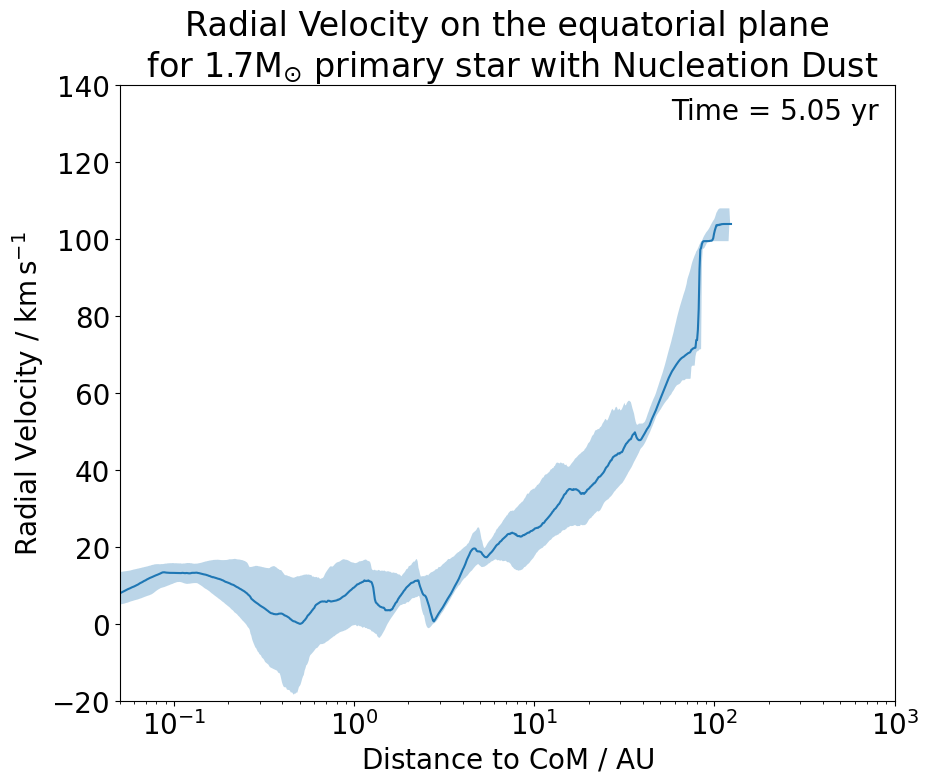

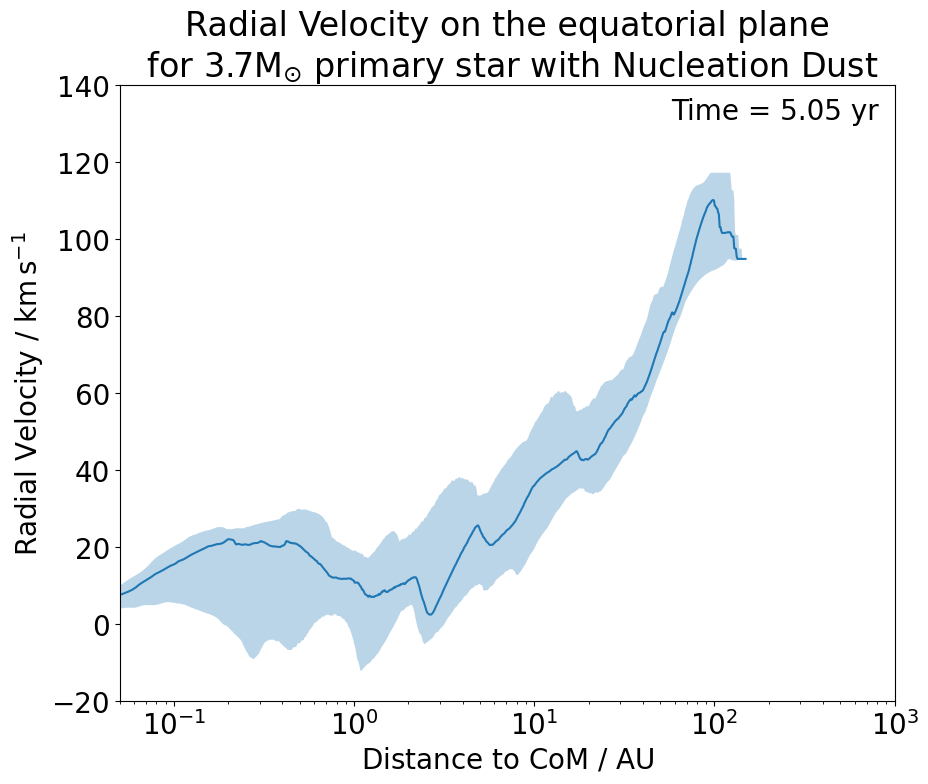

In [31]:
if __name__ == '__main__':

    # plotting

    
    xlim = (0.05, 1e3)
    ylim = (-20, 140)
    quan = 'vr'
    quan_name = 'Radial Velocity'

    
    file_indexes = [2000]

    
    for job_profile in JOB_PROFILES[:2]:
        job_name = job_profile['job_name']

        for file_index in file_indexes:
            

            fig, ax = plt.subplots(figsize=(10, 8))
    
            with open(f"{mupl.get_filename_phantom_dumps(job_name, file_index)}__photosphere-pars-on-ray.json", 'r') as f:
                pars_on_ray = json_load(f)
    
    
            time   = pars_on_ray['dump_info']['time']
            #orbsep = pars_on_ray['dump_info']['orbsep']

            x = pars_on_ray['data']['R1_on_ray'].to(unitsOut['dist'])
            y_data = pars_on_ray['data'][f'{quan}_on_ray'].to(unitsOut['speed'])
            
            #y     = np.average(y_data, axis=0)
            #y_err = np.std(    y_data, axis=0)
            #y_errm = y - y_err
            #y_errp = y + y_err
            y_errm, y, y_errp = np.nanpercentile(y_data, [15.9, 50, 84.1], axis=0)
    
            ax.semilogx(x.value, y.value, '-')    #, label=f"equatorial")    
            ax.fill_between(x.value, y_errm.value, y_errp.value, alpha=0.3)
                    
            
    
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_xlabel(f"Distance to CoM / {x.unit.to_string('latex_inline')}")
            ax.set_ylabel(f"{quan_name} / {y.unit.to_string('latex_inline')}")
    
            ax.text(
                0.98, 0.98,
                f"Time = {time:.2f}",
                color = "black", ha = 'right', va = 'top',
                transform=ax.transAxes,
            )
            #ax.legend() #loc="lower right"

            outfilename_noext = f"../fig/{job_profile['nickname']}_{quan}"
            fig.savefig(f"{outfilename_noext}.pdf")
            ax.set_title(
                f"{quan_name} on the equatorial plane\n"
                #f"resolution = {pars_on_ray['dump_info']['nparttot']:.2e}"
                f"{job_profile['plot_title_suffix']}")
            fig.savefig(f"{outfilename_noext}.png")
            plt.show()
            #plt.close(fig)

In [7]:
pars_on_ray

{'time_yr': 5.050163396140273,
 'orbsep_Rsun': 93.08744299144902,
 'data': {'+x': {'is_found': True,
   'loc': array([ 1.23484152e+04,  5.22238189e+01, -5.28249485e-01]),
   'R1': 12372.272084117447,
   'rho': array(2.79693554e-16),
   'u': array(0.00023333),
   'h': 1725.9063608382176,
   'T': 543.207341234862,
   'kappa': array(2.71646475e+12),
   'size': 12372.272084117447,
   'R1_on_ray': array([1.73867907e+04, 1.72574238e+04, 1.71290194e+04, 1.70015704e+04,
          1.68750697e+04, 1.67495102e+04, 1.66248850e+04, 1.65011870e+04,
          1.63784094e+04, 1.62565454e+04, 1.61355880e+04, 1.60155307e+04,
          1.58963667e+04, 1.57780893e+04, 1.56606919e+04, 1.55441681e+04,
          1.54285112e+04, 1.53137149e+04, 1.51997727e+04, 1.50866784e+04,
          1.49744255e+04, 1.48630078e+04, 1.47524191e+04, 1.46426533e+04,
          1.45337042e+04, 1.44255657e+04, 1.43182319e+04, 1.42116966e+04,
          1.41059541e+04, 1.40009983e+04, 1.38968234e+04, 1.37934237e+04,
          1.369

## Temp vs Rad plots

In [33]:
# Temp vs Rad plots

# relying on script_PhLocAxes

if __name__ == '__main__':

    # settings
    xlim = (1e-1, 2e3)
    labels = ['+x', '+z']    # name of the ray to be plotted
    quans  = ['tau', 'kappa', 'T', 'rho']    # quantities to be plotted
    ylims  = {   # Note: you can supply None
        'tau': (5e-6, 5e5),
        'rho': (5e-20, 5e-6), # None
        'T'  : (1e1, 5e5),
        'kappa': (1e-5, 1e3),
    }
    ylabels = {
        'tau': "\\tau",
        'rho': "\\rho",
        'T'  : "T",
        'kappa': "\\kappa",
    }
    

    # plotting
    for job_profile in JOB_PROFILES:
        job_name    = job_profile['job_name']
        outfilenames = []
        for file_index in job_profile['file_indexes']:
            # load data
            jobfilename = mupl.get_filename_phantom_dumps(job_name, file_index)
            outfilename_noext = f"{jobfilename}__photospherePars__xyz"
            if verbose: print(f"\nWorking on {outfilename_noext}... ", end='')
            with open(f"{outfilename_noext}.json", 'r') as f:
                pars_on_ray = json_load(f)
        
            time = set_as_quantity(pars_on_ray['time_yr'], units.yr)
            #orbsep_Rsun = np.array(pars_on_ray['orbsep_Rsun'])

        
            fig, axes = plt.subplots(len(quans), figsize=(10, 2+4*len(quans)), squeeze=False, sharex=True)
            fig.subplots_adjust(hspace=0.0, wspace=0.0)

            xerrs_dict = {}
            for i, label in enumerate(labels):
                photosphere = pars_on_ray['data'][label]
                xval  = get_val_in_unit(photosphere['R1'       ], unitsIn['dist'], unitsOut['dist'])
                xerr  = get_val_in_unit(photosphere['h'        ], unitsIn['dist'], unitsOut['dist'])
                xvals = get_val_in_unit(photosphere['R1_on_ray'], unitsIn['dist'], unitsOut['dist'])
                xerrs_dict[label] = (xval, xerr, xvals)
                
                
            for ax, quan in zip(axes, quans):
                ax = ax[0]
                ylim = ylims[quan] if quan in ylims.keys() else None
                ylabel = ylabels[quan] if quan in ylabels.keys() else None
                if quan in {'kappaDust'}:
                    unit_name = 'opacity'
                else:
                    unit_name = get_units_field_name(quan)
                valtxts = []
                yvaltxt_logs = []
                yerrs_dict = {}
                
                for i, label in enumerate(labels):
                    photosphere = pars_on_ray['data'][label]
                    xval, xerr, xvals = xerrs_dict[label]
                    xerrp = xval + xerr
                    xerrm = xval - xerr

                    yvals = get_val_in_unit(photosphere[f'{quan}_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                    yval, yerrp, yerrm = get_yval_yerr(xval, xerrp, xerrm, xvals, yvals)
                    dyerrp = yerrp - yval
                    dyerrm = yerrm - yval
                    # store it for later because we want them to be on the same scale for +x and +z
                    yerrs_dict[label] = (yval, dyerrp, dyerrm)
                    
                    ax.loglog(xvals, yvals, color=f'C{i}', label=label)
                    ax.set_xlim(xlim)
                    ax.set_ylim(ylim)
                    ax.fill_betweenx(
                        ax.get_ylim(),
                        get_val_in_unit(photosphere['R1'] - photosphere['h'], unitsIn['dist'], unitsOut['dist']),
                        get_val_in_unit(photosphere['R1'] + photosphere['h'], unitsIn['dist'], unitsOut['dist']),
                        color=f'C{i}', alpha=0.1)
                    ax.set_ylabel(f"${ylabel}$ / {unitsOutTxt[unit_name]}" if unit_name != 'dimless' else f"${ylabel}$")
                    if quan == 'tau':
                        ax.axhline(PHOTOSPHERE_TAU, color='grey', linestyle='dashed')

                    # get the scale of the value for the exact val & err text
                    try:
                        yvaltxt_log = np.log10(np.abs([yval, dyerrm, dyerrp]))
                        yvaltxt_log = int(np.floor(np.average(yvaltxt_log[np.isfinite(yvaltxt_log)])))
                        if quan in ['tau','T']:
                            # mannual override
                            yvaltxt_log = 0
                    except ValueError:
                        yvaltxt_log = 0
                    yvaltxt_logs.append(yvaltxt_log)


                # get val text
                for label in labels:
                    # init
                    yvaltxt_log = min(yvaltxt_logs)
                    yval, dyerrp, dyerrm = yerrs_dict[label]
                    
                    # ignore small scales
                    if yvaltxt_log == 1: yvaltxt_log = 0
                        
                    yvaltxt  = f"${ylabel}_{{{label}}} ="
                    yvaltxt += f"{yval/10**yvaltxt_log:.1f}^{{{dyerrp/10**yvaltxt_log:+.1f}}}_{{{dyerrm/10**yvaltxt_log:+.1f}}}$"
                    if yvaltxt_log != 0: yvaltxt += f" $10^{{{yvaltxt_log}}}$"
                    yvaltxt += f" {unitsOutTxt[unit_name]}"
                    yvaltxt += f" ({(abs(dyerrp)+abs(dyerrm))/yval/2:.0%})"
                    
                    valtxts.append(yvaltxt)
                    
                ax.text(xlim[0], ylim[0], '\n'.join(valtxts), ha='left', va='bottom')
            ax.set_xlabel(f"$R_1$ / {unitsOutTxt['dist']}")
            ax.legend(loc='upper right')

            # set title and time label
            ax = axes[0][0]
            ax_txts = [f"Time = {time:.1f}"]
            for label in labels:
                xval, xerr, _ = xerrs_dict[label]
                ax_txts.append(f"$R_{{1, \\mathrm{{{label}, ph}}}} = {xval:.1f} \\pm {xerr:.1f}$ {unitsOutTxt['dist']}")
            
            ax.text(
                0.98, 0.98,
                '\n'.join(ax_txts),
                color = "black", ha = 'right', va = 'top',
                transform=ax.transAxes,
            )
            ax.set_title(
                f"Properties along one singe ray\n" + \
                #f"resolution = {photospheres['dump_info']['nparttot']:.2e}\n" + \
                f"{job_profile['plot_title_suffix']}",
            )
            # save fig
            outfilename = f"{jobfilename}__singleRayProperties.png"
            outfilenames.append(outfilename)
            fig.savefig(outfilename)
            plt.close(fig)
            if verbose: print(f"Done.\n")

        # define job_folder_prefix
        for i in range(len(job_name)-1, -1, -1):
            if job_name[i] == path.sep:
                job_folder_prefix = job_name[:i]
                break
            else:
                job_folder_prefix = job_name
        with ImageSequenceClip(outfilenames, fps=fps) as vid:
            moviefilename = f"{job_folder_prefix}__singleRayProperties__movie.mp4"
            vid.write_videofile(moviefilename)

    if verbose: print("\n\n\n*** All Done. ***\n\n\n")


Working on ../photosphere/luis_2md/light_00000__photospherePars__xyz... 

FileNotFoundError: [Errno 2] No such file or directory: '../photosphere/luis_2md/light_00000__photospherePars__xyz.json'

## Temp vs Rad plots (added dust shell tau)


Working on ../interm/2md_04800.photospherePars.xyz... label = '+x', shell_tau_dict[label] = 25.880001016557518, shell_loc_dict[label] = 94.9799108520019
label = '+z', shell_tau_dict[label] = 23.812537396571855, shell_loc_dict[label] = 81.32320874095069


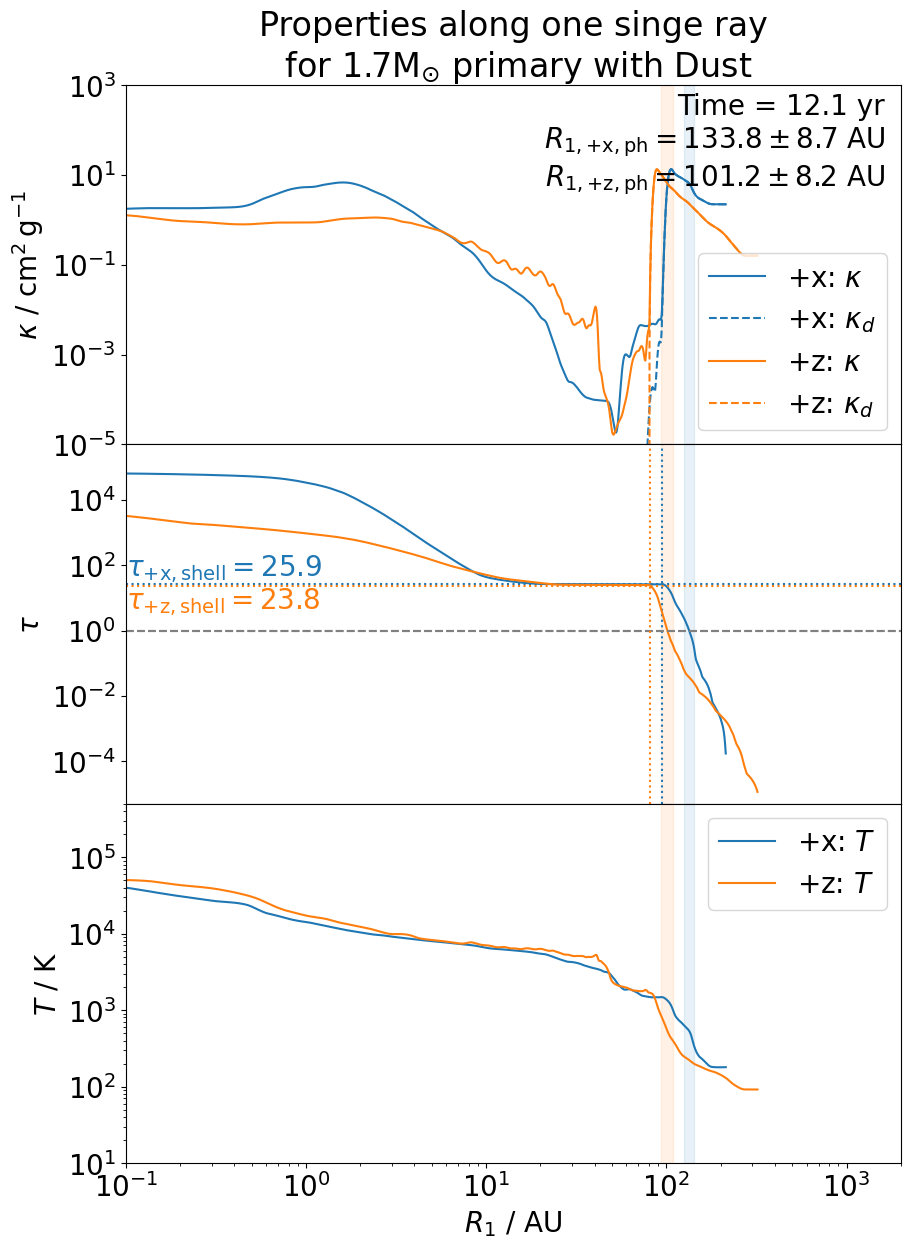


Working on ../interm/2md_15600.photospherePars.xyz... label = '+x', shell_tau_dict[label] = 239.95636989205343, shell_loc_dict[label] = 0.04650467260962157
label = '+z', shell_tau_dict[label] = 90.5636789294577, shell_loc_dict[label] = 0.04650467260962157


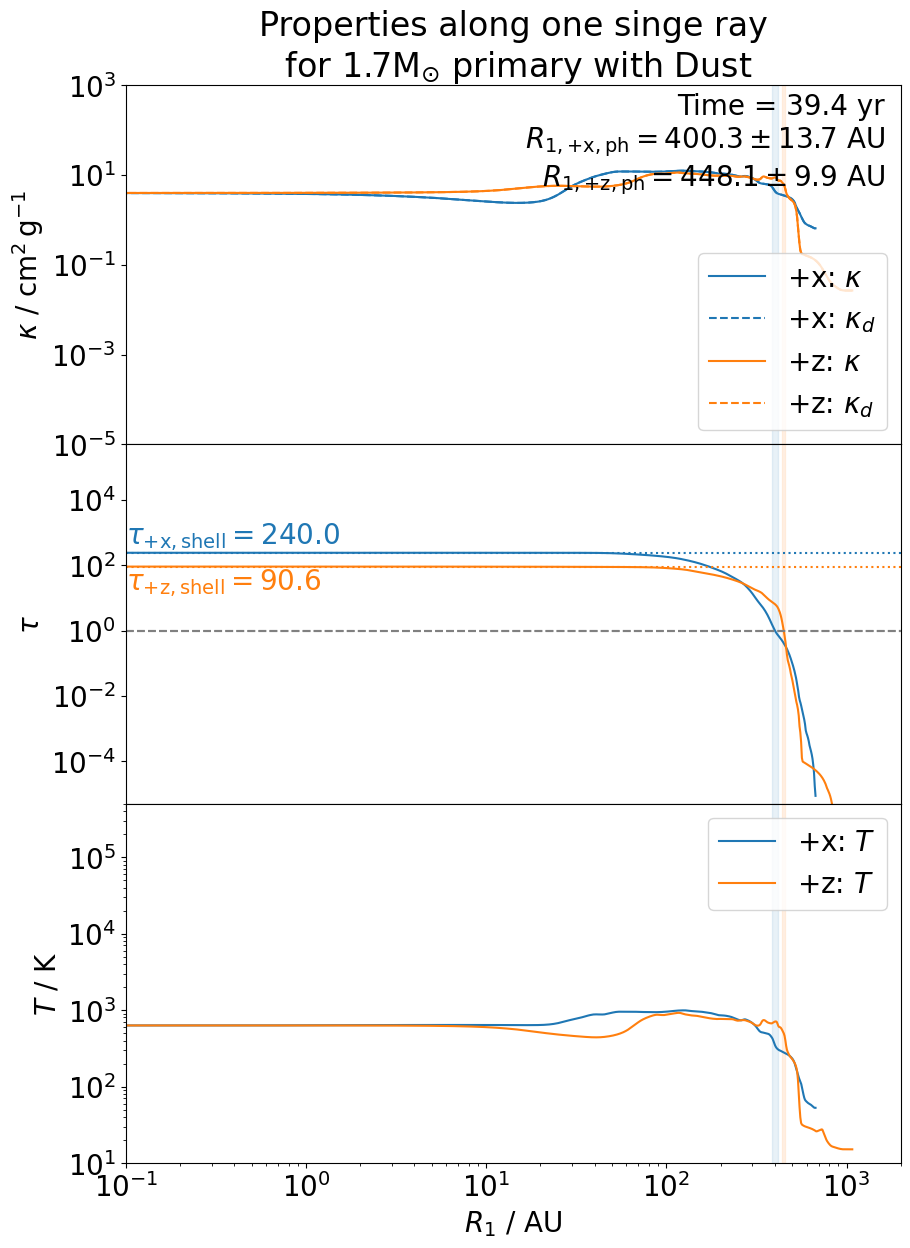


Working on ../interm/4md_04800.photospherePars.xyz... label = '+x', shell_tau_dict[label] = 12.96899494159122, shell_loc_dict[label] = 103.0807268315661
label = '+z', shell_tau_dict[label] = 20.37610029420358, shell_loc_dict[label] = 87.87686025392516


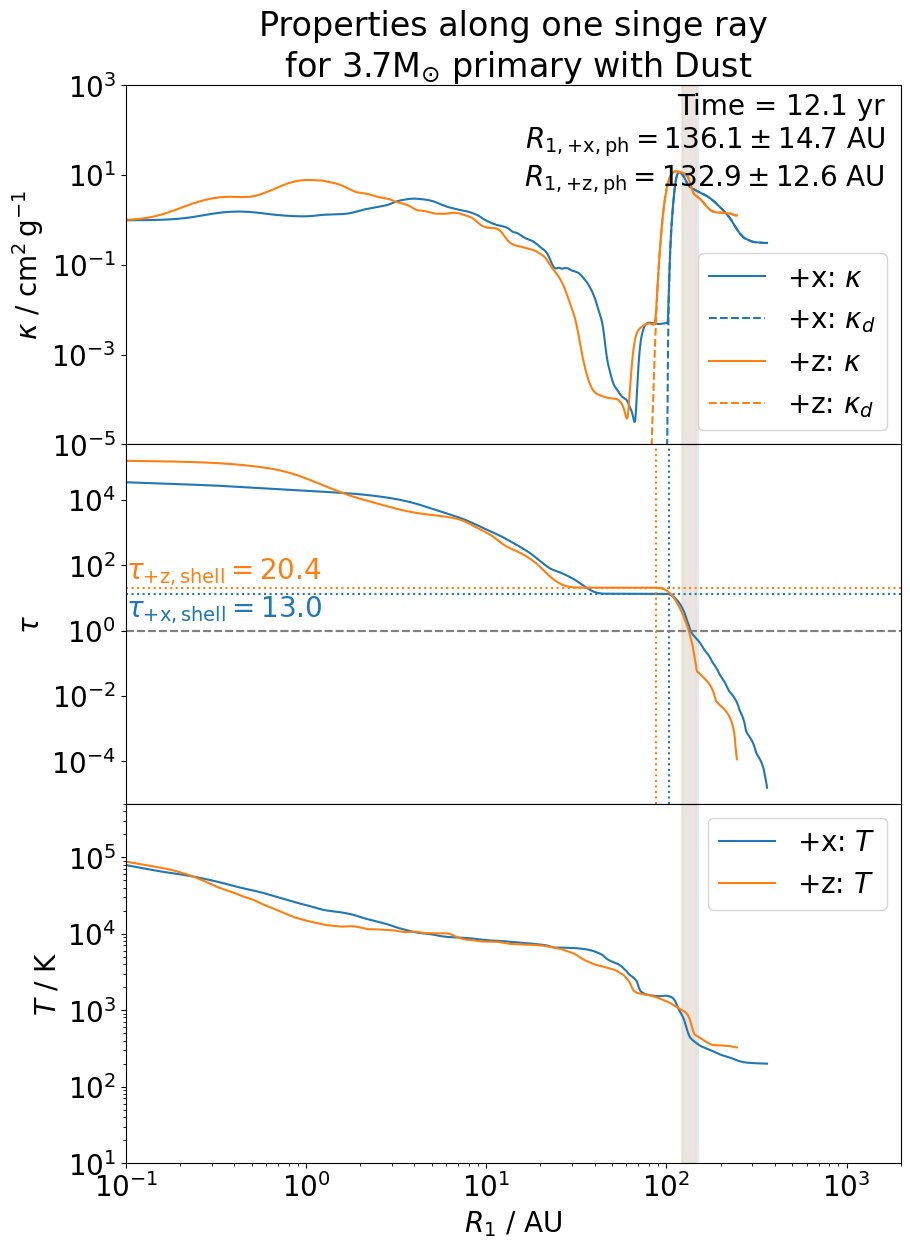


Working on ../interm/4md_17600.photospherePars.xyz... label = '+x', shell_tau_dict[label] = 369.64666762785316, shell_loc_dict[label] = 5.201183542672468
label = '+z', shell_tau_dict[label] = 621.9353490883186, shell_loc_dict[label] = 2.649166686466137


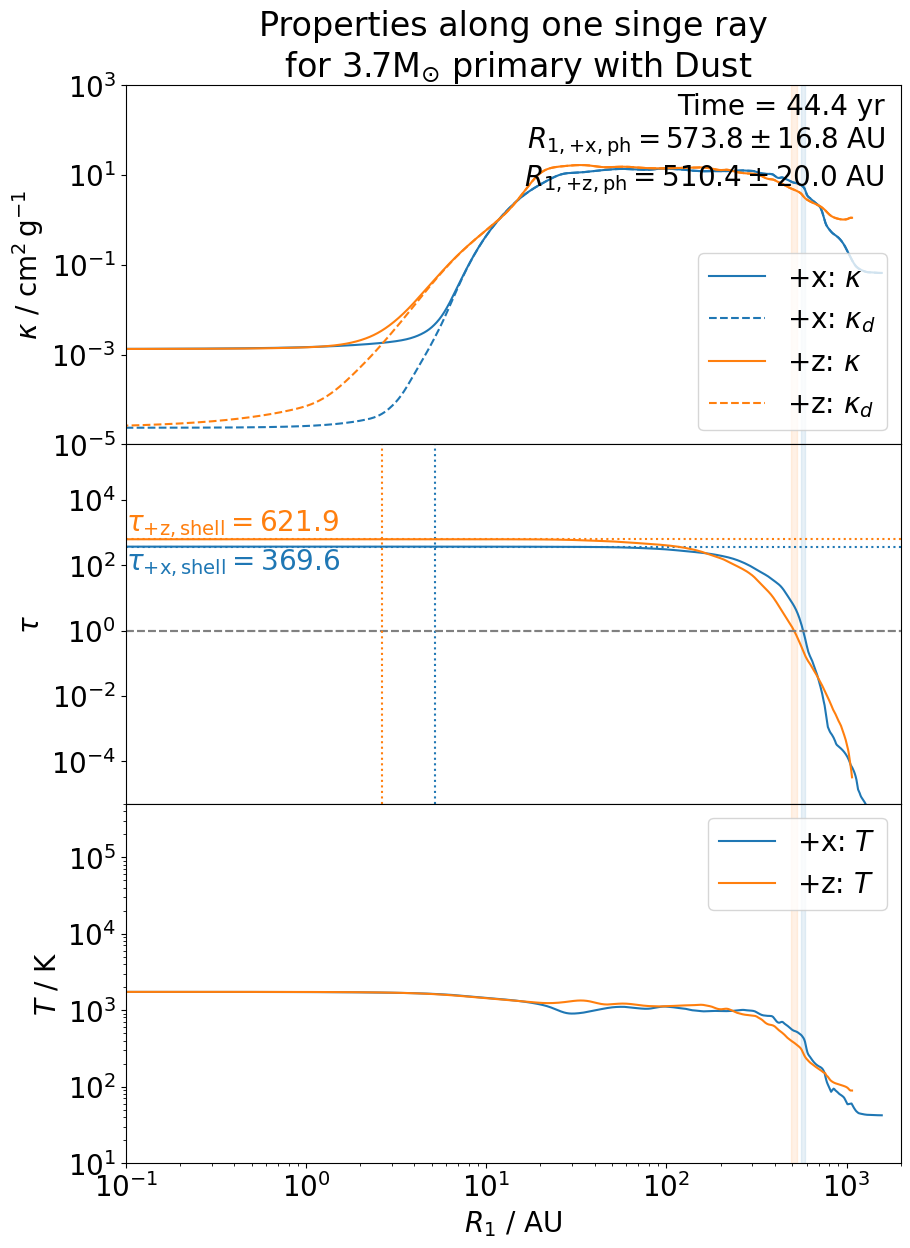

In [7]:
# debug mode 20240624 - added dust shell tau calculations
do_debug = True
if do_debug:
    xlim = (1e-1, 2e3)
    labels = ['+x', '+z']    # name of the ray to be plotted
    quans  = ['kappa', 'tau', 'T'] #['tau', 'kappa', 'T', 'rho']    # quantities to be plotted
    ylims  = {   # Note: you can supply None
        'tau': (5e-6, 5e5),
        'rho': (5e-20, 5e-6), # None
        'T'  : (1e1, 5e5),
        'kappa': (1e-5, 1e3),
        'kappaDust': (1e-5, 1e3),
    }
    ylabels = {
        'tau': "\\tau",
        'rho': "\\rho",
        'T'  : "T",
        'kappa': "\\kappa",
        'kappaDust': "\\kappa_d",
    }
    file_indexes_dict = {
        '2md': (4800, 15600,),
        '4md': (4800, 17600,),
    }
    # fraction of the kappa_dust where dust shell is considered as ending
    #     setting it to None to disable calculations and displays of dust shell optical depth
    shell_kappa_frac : None|float = 0.5
    do_plot_val_txts : bool = False
    

    # plotting
    for job_profile in [JOB_PROFILES_DICT[nickname] for nickname in file_indexes_dict.keys()]:
        job_name     = job_profile['job_name']
        job_nickname = job_profile['nickname']
        outfilenames = []
        for file_index in file_indexes_dict[job_nickname]:
            # load data
            jobfilename = mupl.get_filename_phantom_dumps(job_name, file_index)
            #outfilename_noext = f"{jobfilename}__photospherePars__xyz"
            outfilename_noext = f"{interm_dir}{job_nickname}_{file_index:05d}.photospherePars.xyz"
            if verbose: print(f"\nWorking on {outfilename_noext}... ", end='')
            with open(f"{outfilename_noext}.json", 'r') as f:
                pars_on_ray = json_load(f)
        
            time = set_as_quantity(pars_on_ray['time_yr'], units.yr)
            #orbsep_Rsun = np.array(pars_on_ray['orbsep_Rsun'])

            plt.close()
            fig, axes = plt.subplots(len(quans), figsize=(10, 2+4*len(quans)), squeeze=False, sharex=True)
            fig.subplots_adjust(hspace=0.0, wspace=0.0)

            xerrs_dict = {}
            if shell_kappa_frac is not None:
                shell_tau_dict = {}
                shell_loc_dict = {}
            for i, label in enumerate(labels):
                photosphere = pars_on_ray['data'][label]
                xval  = get_val_in_unit(photosphere['R1'       ], unitsIn['dist'], unitsOut['dist'])
                xerr  = get_val_in_unit(photosphere['h'        ], unitsIn['dist'], unitsOut['dist'])
                xvals = get_val_in_unit(photosphere['R1_on_ray'], unitsIn['dist'], unitsOut['dist'])
                xerrs_dict[label] = (xval, xerr, xvals)

                # getting dust shell optical depth
                if shell_kappa_frac is not None:
                    unit_name = 'opacity'
                    # note the results are in reversed order
                    kappa     = get_val_in_unit(photosphere[f'kappa_on_ray'    ], unitsIn[unit_name], unitsOut[unit_name])
                    kappaDust = get_val_in_unit(photosphere[f'kappaDust_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                    # dust shell inner edge index
                    inner_ind = np.where(kappaDust > kappa * shell_kappa_frac)[0][-1]
                    unit_name = 'dimless'
                    shell_tau = get_val_in_unit(photosphere[f'tau_on_ray'], unitsIn[unit_name], unitsOut[unit_name])[inner_ind]
                    shell_tau_dict[label] = shell_tau
                    shell_loc_dict[label] = xvals[inner_ind]
            
                
                
            for ax, quan in zip(axes, quans):
                ax = ax[0]
                ylim = ylims[quan] if quan in ylims.keys() else None
                ylabel = ylabels[quan] if quan in ylabels.keys() else None
                if quan in {'kappaDust'}:
                    unit_name = 'opacity'
                else:
                    unit_name = get_units_field_name(quan)
                valtxts = []
                yvaltxt_logs = []
                yerrs_dict = {}
                
                for i, label in enumerate(labels):
                    photosphere = pars_on_ray['data'][label]
                    xval, xerr, xvals = xerrs_dict[label]
                    xerrp = xval + xerr
                    xerrm = xval - xerr

                    yvals = get_val_in_unit(photosphere[f'{quan}_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                    yval, yerrp, yerrm = get_yval_yerr(xval, xerrp, xerrm, xvals, yvals)
                    dyerrp = yerrp - yval
                    dyerrm = yerrm - yval
                    # store it for later because we want them to be on the same scale for +x and +z
                    yerrs_dict[label] = (yval, dyerrp, dyerrm)
                    
                    ax.loglog(xvals, yvals, color=f'C{i}', label=f"{label}: ${ylabels[quan]}$")
                    if   quan == 'kappa':
                        quan_alt  = 'kappaDust'
                        yvals_alt = get_val_in_unit(photosphere[f'{quan_alt}_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                        ax.loglog(xvals, yvals_alt, '--', color=f'C{i}', label=f"{label}: ${ylabels[quan_alt]}$")
                        ax.legend(loc='lower right')
                    elif quan == 'tau':
                        # add texts
                        ax.axhline(PHOTOSPHERE_TAU, color='grey', linestyle='dashed')
                        # show optical depth of dust shell
                        if shell_kappa_frac is not None:
                            shell_tau = shell_tau_dict[label]
                            shell_loc = shell_loc_dict[label]
                            ax.axhline(shell_tau, color=f'C{i}', linestyle='dotted')
                            ax.axvline(shell_loc, color=f'C{i}', linestyle='dotted')
                            # display only first 2 values so the texts are not crowded
                            va = False
                            if i == 0 or i == 1:
                                va = 'top' if shell_tau < shell_tau_dict[labels[1-i]] else 'bottom'
                            if va:
                                ax.text(xlim[0], shell_tau,
                                    f"$\\tau_\\mathrm{{{label}, shell}} = {shell_tau:.1f}$",
                                    color=f'C{i}', ha='left', va=va)
                            # print all exact value if verbose
                            if verbose: print(f"{label = }, {shell_tau_dict[label] = }, {shell_loc_dict[label] = }")
                    ax.set_xlim(xlim)
                    ax.set_ylim(ylim)
                    ax.fill_betweenx(
                        ax.get_ylim(),
                        get_val_in_unit(photosphere['R1'] - photosphere['h'], unitsIn['dist'], unitsOut['dist']),
                        get_val_in_unit(photosphere['R1'] + photosphere['h'], unitsIn['dist'], unitsOut['dist']),
                        color=f'C{i}', alpha=0.1)
                    ax.set_ylabel(f"${ylabel}$ / {unitsOutTxt[unit_name]}" if unit_name != 'dimless' else f"${ylabel}$")
                        

                    # get the scale of the value for the exact val & err text
                    try:
                        yvaltxt_log = np.log10(np.abs([yval, dyerrm, dyerrp]))
                        yvaltxt_log = int(np.floor(np.average(yvaltxt_log[np.isfinite(yvaltxt_log)])))
                        if quan in ['tau','T']:
                            # mannual override
                            yvaltxt_log = 0
                    except ValueError:
                        yvaltxt_log = 0
                    yvaltxt_logs.append(yvaltxt_log)


                # get val text
                if do_plot_val_txts:
                    for label in labels:
                        # init
                        yvaltxt_log = min(yvaltxt_logs)
                        yval, dyerrp, dyerrm = yerrs_dict[label]
                        
                        # ignore small scales
                        if yvaltxt_log == 1: yvaltxt_log = 0
                            
                        yvaltxt  = f"${label}: {ylabel} ="
                        yvaltxt += f"{yval/10**yvaltxt_log:.1f}^{{{dyerrp/10**yvaltxt_log:+.1f}}}_{{{dyerrm/10**yvaltxt_log:+.1f}}}$"
                        if yvaltxt_log != 0: yvaltxt += f" $10^{{{yvaltxt_log}}}$"
                        yvaltxt += f" {unitsOutTxt[unit_name]}"
                        #yvaltxt += f" ({(abs(dyerrp)+abs(dyerrm))/yval/2:.0%})"
                        
                        valtxts.append(yvaltxt)
    
                    ax.text(xlim[0], ylim[0], '\n'.join(valtxts), ha='left', va='bottom')
            ax.set_xlabel(f"$R_1$ / {unitsOutTxt['dist']}")
            ax.legend(loc='upper right')

            # set title and time label
            ax = axes[0][0]
            ax_txts = [f"Time = {time:.1f}"]
            for label in labels:
                xval, xerr, _ = xerrs_dict[label]
                ax_txts.append(f"$R_{{1, \\mathrm{{{label}, ph}}}} = {xval:.1f} \\pm {xerr:.1f}$ {unitsOutTxt['dist']}")
            
            ax.text(
                0.98, 0.98,
                '\n'.join(ax_txts),
                color = "black", ha = 'right', va = 'top',
                transform=ax.transAxes,
            )
            ax.set_title(
                f"Properties along one singe ray\n" + \
                #f"resolution = {photospheres['dump_info']['nparttot']:.2e}\n" + \
                f"{job_profile['plot_title_suffix']}",
            )
            # save fig
            outfilename = f"{output_dir}{job_nickname}_{file_index:05d}__singleRayProperties.png"
            fig.savefig(outfilename)
            outfilenames.append(outfilename)
            plt.show(fig)

## Plotting S kappa rho vs Rad

In [35]:
help(mupl.sph_interp.get_no_neigh)

Help on function get_no_neigh in module clmuphantomlib.sph_interp:

get_no_neigh(sdf: sarracen.sarracen_dataframe.SarracenDataFrame, locs: numpy.ndarray, kernel: None | sarracen.kernels.base_kernel.BaseKernel = None, kernel_rad: None | float = None, ndim: int = 3, xyzs_names_list: list = ['x', 'y', 'z'], verbose: int = 3) -> numpy.ndarray | int
    Get the number of neighbour particles.
    
    Pending optimization (add kd-tree?)
    
    Parameters
    ----------
    sdf: sarracen.SarracenDataFrame
        Must contain columns: x, y, z, h.
        if hfact is None or kernel is None, will get from sdf.
        
    locs: np.ndarray
        (3) or (..., 3)-shaped array determining the location for neighbour counting.
        
    kernel: sarracen.kernels.base_kernel
    kernel_rad: float
        radius of the smoothing kernel in unit of smoothing length
        If None, will infer from kernel; if kernel is also None, will use the one in sdf.
        
    ndim: int
        dimension of 


Working on ../interm/2md_00000.photospherePars.xyz... 

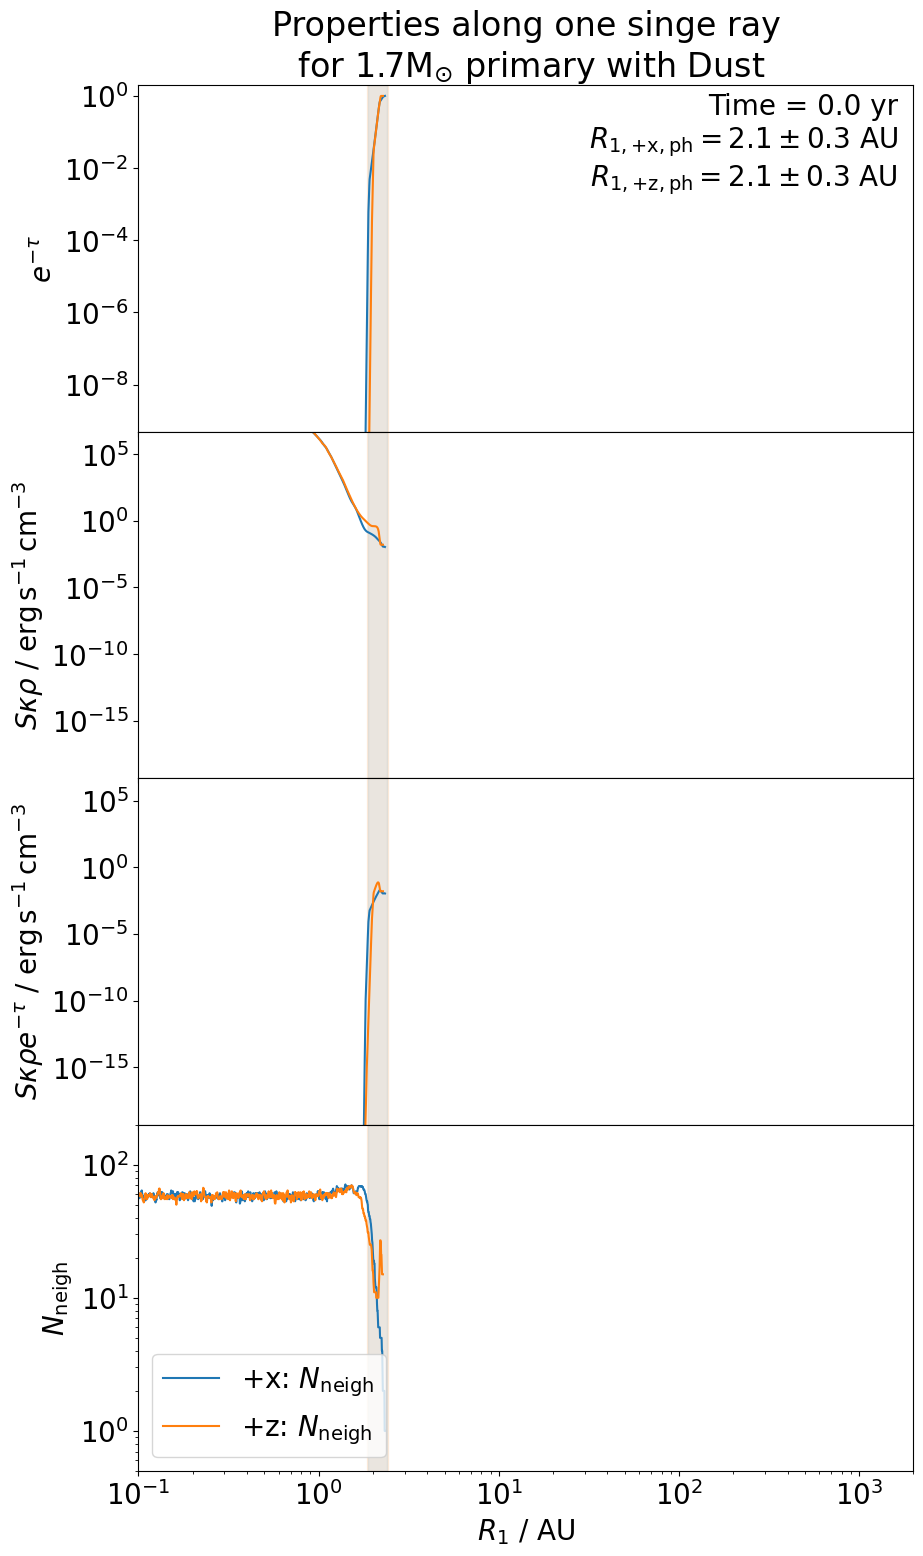


Working on ../interm/2md_01200.photospherePars.xyz... 

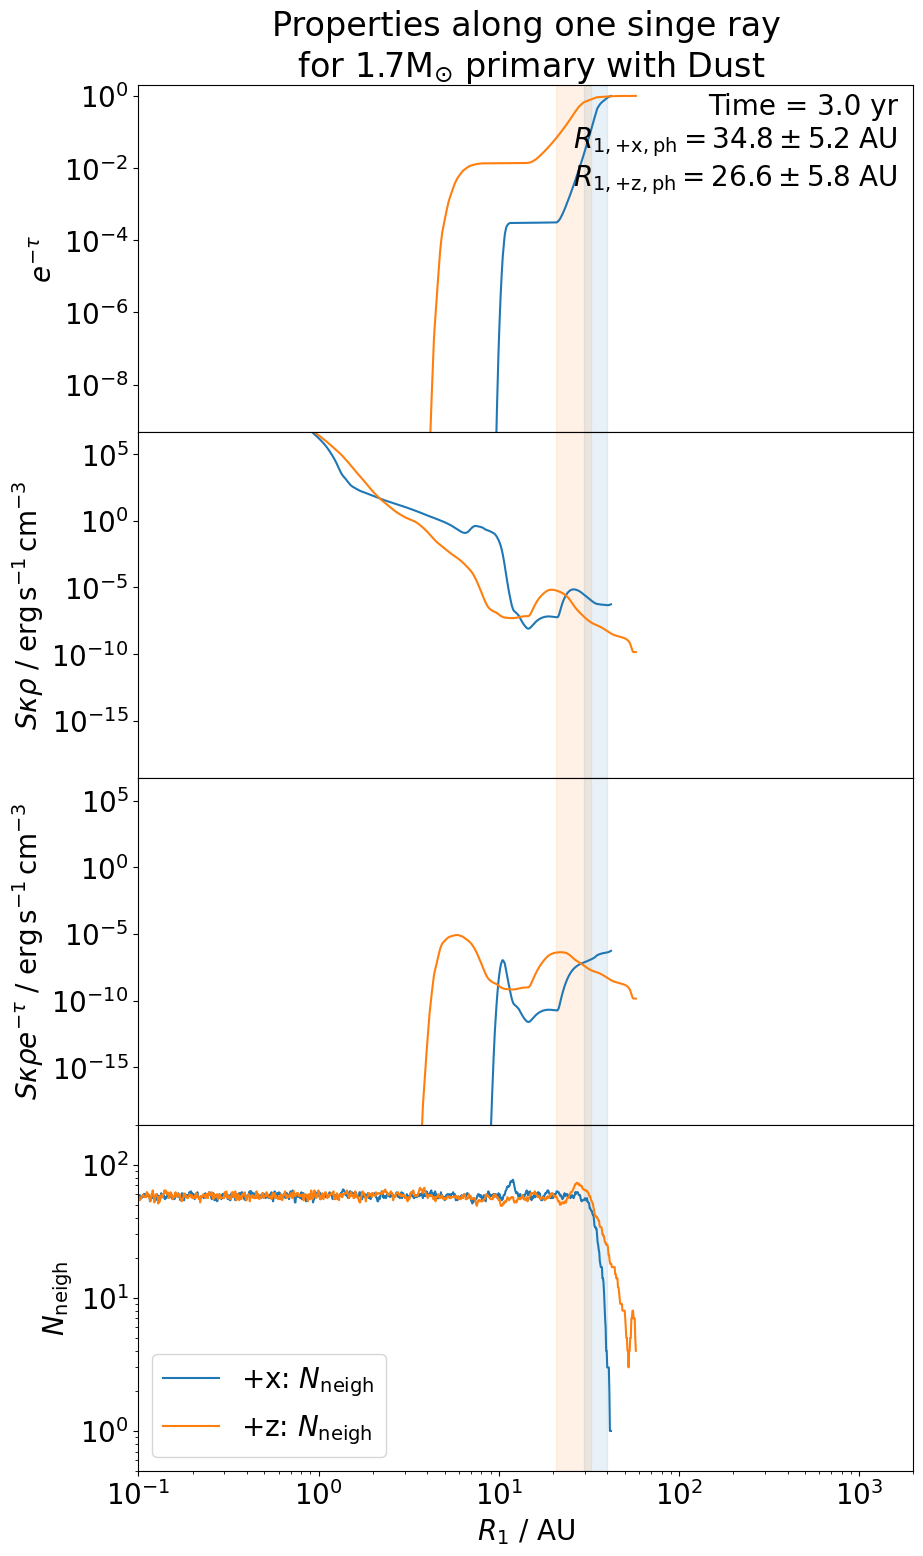


Working on ../interm/2md_04800.photospherePars.xyz... 

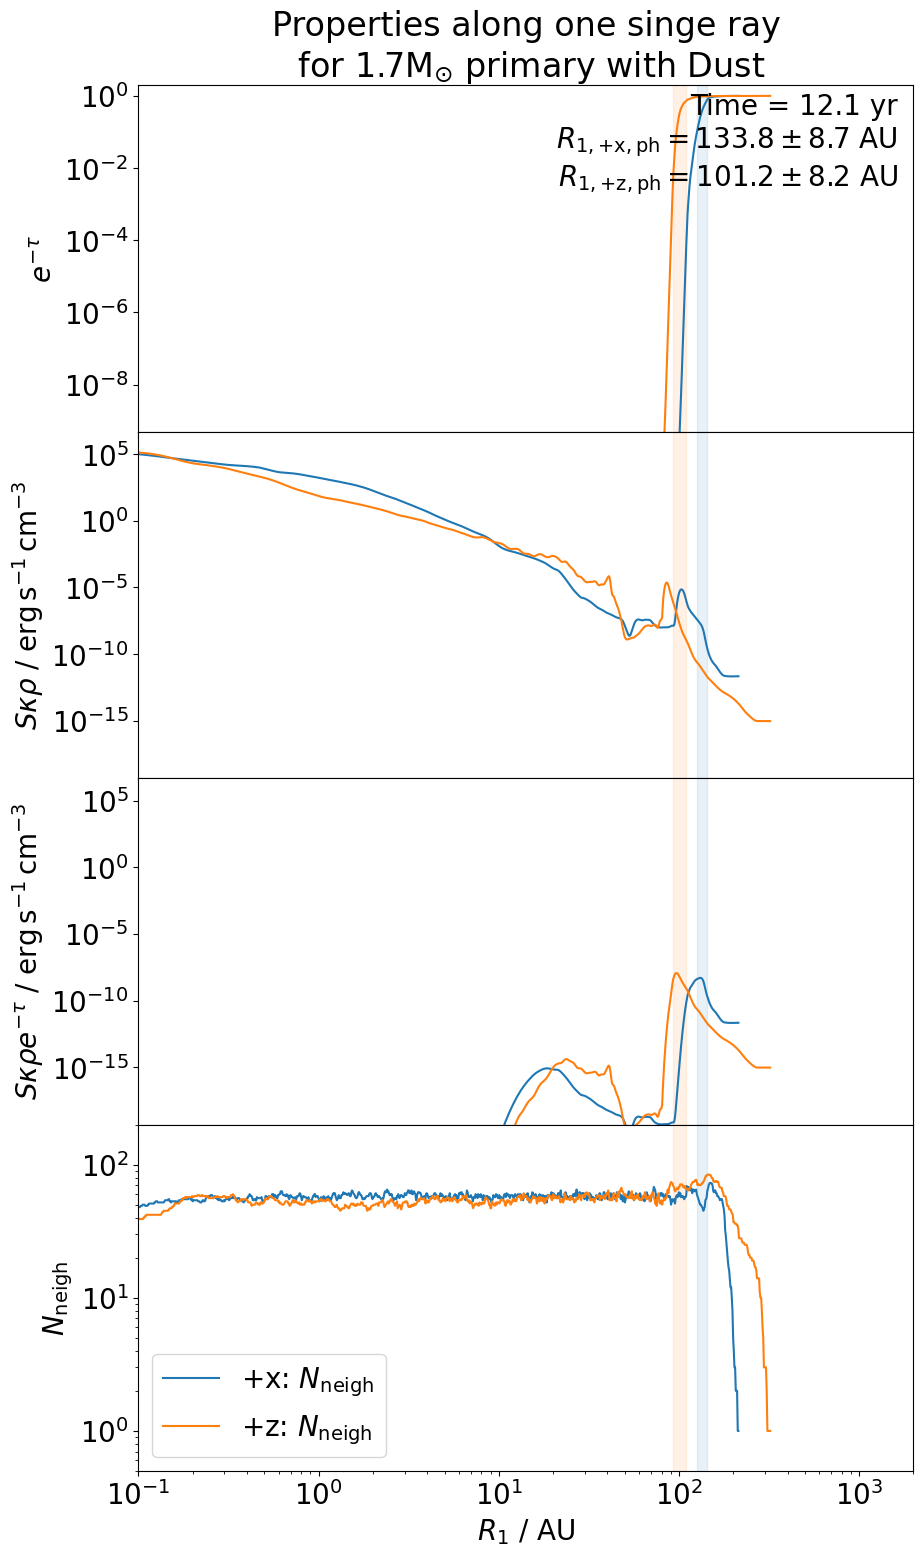


Working on ../interm/2md_15600.photospherePars.xyz... 

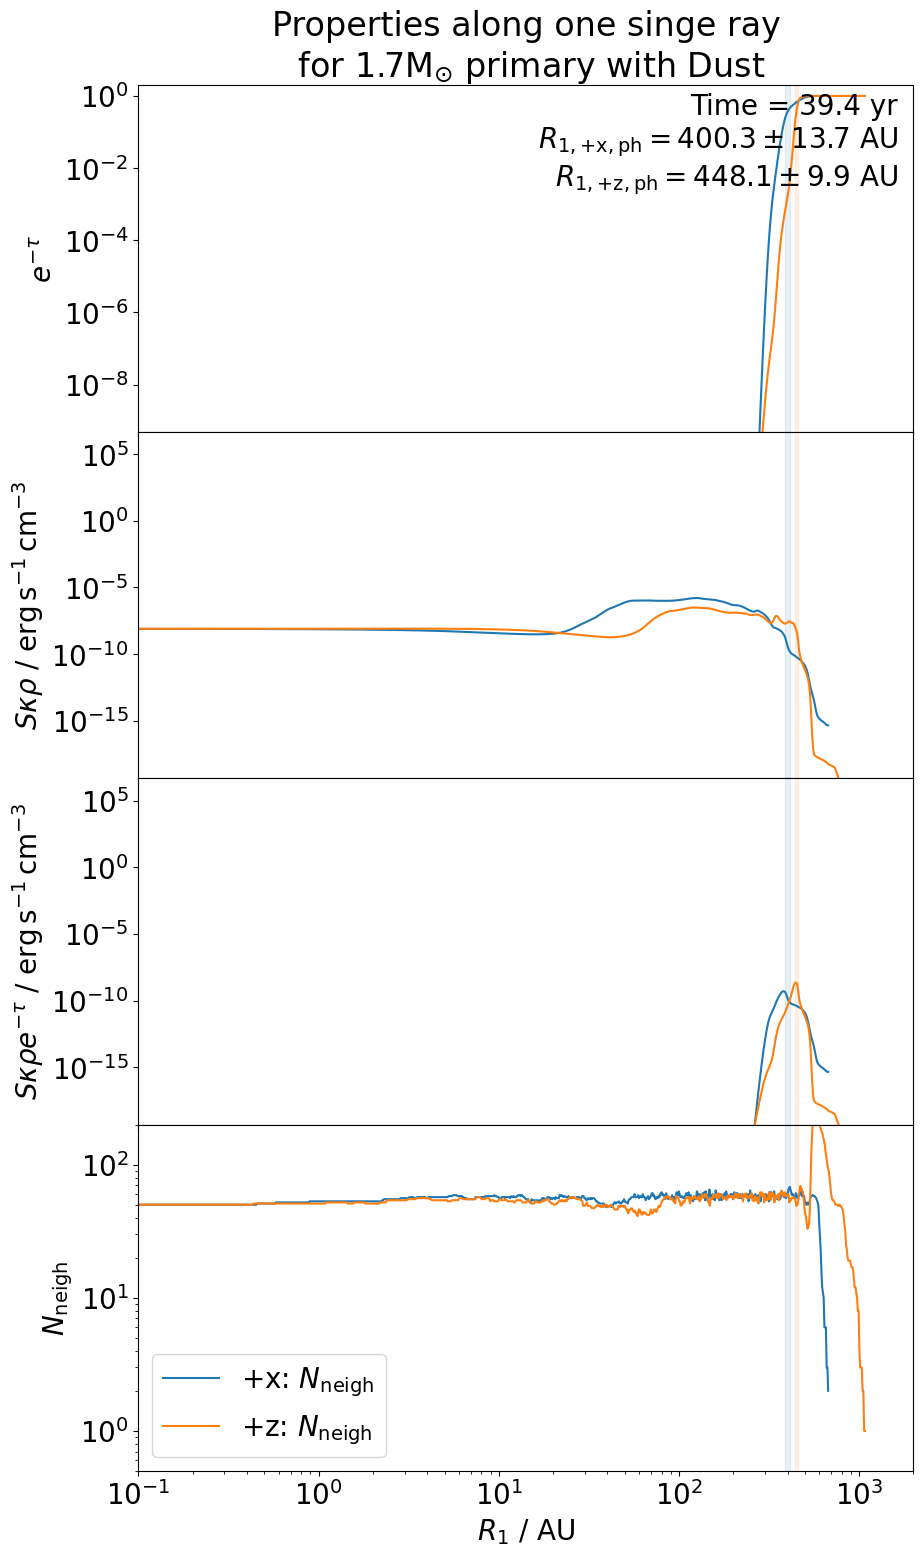

In [12]:
# debug mode 20240625 - S kappa rho vs rad
do_debug = True
if do_debug:
    xlim = (1e-1, 2e3)
    labels = ['+x', '+z']    # name of the ray to be plotted
    quans  = ['exp_mtau', 'S_kappa_rho', 'Skr_expmtau', 'nneigh'] #['tau', 'kappa', 'T', 'rho']    # quantities to be plotted
    ylims  = {   # Note: you can supply None
        'tau': (5e-6, 5e5),
        'rho': (5e-20, 5e-6), # None
        'T'  : (1e1, 5e5),
        'S'  : (5e1, 5e16),
        'nneigh': (.5, 200.),
        'kappa': (1e-5, 1e3),
        'kappaDust': (1e-5 , 1e3),
        'exp_mtau' : (5e-10, 2e0),
        'S_kappa_rho': (5e-20, 5e6),
        'Skr_expmtau': (5e-20, 5e6),
    }
    ylabels = {
        'tau': "\\tau",
        'rho': "\\rho",
        'T'  : "T",
        'S'  : "S",
        'nneigh': "N_\\mathrm{neigh}",
        'kappa': "\\kappa",
        'kappaDust': "\\kappa_d",
        'exp_mtau' : "e^{-\\tau}",
        'S_kappa_rho' : "S \\kappa \\rho",
        'Skr_expmtau' : "S \\kappa \\rho e^{-\\tau}",
    }
    file_indexes_dict = {
        '2md': (0, 1200, 4800, 15600,),
        #'4md': (1200, 4800, 17600,),
    }
    # fraction of the kappa_dust where dust shell is considered as ending
    #     setting it to None to disable calculations and displays of dust shell optical depth
    shell_kappa_frac : None|float = 0.5
    do_plot_val_txts : bool = False

    
    unitsIn['S_kappa_rho'] = unitsIn['flux'] * unitsIn['opacity'] * unitsIn['density']

    # plotting
    for job_profile in [JOB_PROFILES_DICT[nickname] for nickname in file_indexes_dict.keys()]:
        job_name     = job_profile['job_name']
        job_nickname = job_profile['nickname']
        outfilenames = []
        for file_index in file_indexes_dict[job_nickname]:
            # load data
            jobfilename = mupl.get_filename_phantom_dumps(job_name, file_index)
            #outfilename_noext = f"{jobfilename}__photospherePars__xyz"
            outfilename_noext = f"{interm_dir}{job_nickname}_{file_index:05d}.photospherePars.xyz"
            if verbose: print(f"\nWorking on {outfilename_noext}... ", end='')
            with open(f"{outfilename_noext}.json", 'r') as f:
                pars_on_ray = json_load(f)
        
            time = set_as_quantity(pars_on_ray['time_yr'], units.yr)
            #orbsep_Rsun = np.array(pars_on_ray['orbsep_Rsun'])

            plt.close()
            fig, axes = plt.subplots(len(quans), figsize=(10, 2+4*len(quans)), squeeze=False, sharex=True)
            fig.subplots_adjust(hspace=0.0, wspace=0.0)

            xerrs_dict = {}
            if shell_kappa_frac is not None:
                shell_tau_dict = {}
                shell_loc_dict = {}
            for i, label in enumerate(labels):
                photosphere = pars_on_ray['data'][label]

                # calc additional quans
                if {'S', 'exp_mtau', 'S_kappa_rho', 'Skr_expmtau'}.intersection(quans):
                    photosphere['exp_mtau_on_ray'] = np.exp(-photosphere['tau_on_ray'])
                    photosphere['S_on_ray'] = (
                        const.sigma_sb * set_as_quantity(photosphere['T_on_ray'], unitsIn['temp'])**4 / pi
                    ).to(unitsIn['flux'])
                    photosphere['S_kappa_rho_on_ray'] = (
                        set_as_quantity(photosphere['S_on_ray'    ], unitsIn['flux']) *
                        set_as_quantity(photosphere['kappa_on_ray'], unitsIn['opacity']) *
                        set_as_quantity(photosphere['rho_on_ray'  ], unitsIn['density'])
                    ).to(unitsIn['S_kappa_rho'])
                    photosphere['Skr_expmtau_on_ray'] = (
                        set_as_quantity(photosphere['S_kappa_rho_on_ray'], unitsIn['S_kappa_rho']) *
                        set_as_quantity(photosphere['exp_mtau_on_ray'   ], unitsIn['dimless'])
                    ).to(unitsIn['S_kappa_rho'])

                # set x vals
                xval  = get_val_in_unit(photosphere['R1'       ], unitsIn['dist'], unitsOut['dist'])
                xerr  = get_val_in_unit(photosphere['h'        ], unitsIn['dist'], unitsOut['dist'])
                xvals = get_val_in_unit(photosphere['R1_on_ray'], unitsIn['dist'], unitsOut['dist'])
                xerrs_dict[label] = (xval, xerr, xvals)

                # getting dust shell optical depth
                if shell_kappa_frac is not None:
                    unit_name = 'opacity'
                    # note the results are in reversed order
                    kappa     = get_val_in_unit(photosphere[f'kappa_on_ray'    ], unitsIn[unit_name], unitsOut[unit_name])
                    kappaDust = get_val_in_unit(photosphere[f'kappaDust_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                    # dust shell inner edge index
                    inner_inds= np.where(kappaDust > kappa * shell_kappa_frac)[0]
                    inner_ind = inner_inds[-1] if inner_inds.size else 0
                    unit_name = 'dimless'
                    shell_tau = get_val_in_unit(photosphere[f'tau_on_ray'], unitsIn[unit_name], unitsOut[unit_name])[inner_ind]
                    shell_tau_dict[label] = shell_tau
                    shell_loc_dict[label] = xvals[inner_ind]
            
                
                
            for ax, quan in zip(axes, quans):
                ax = ax[0]
                ylim = ylims[quan] if quan in ylims.keys() else None
                ylabel = ylabels[quan] if quan in ylabels.keys() else None
                # specify units
                if quan in {'kappaDust'}:
                    unit_name = 'opacity'
                elif quan in {'exp_mtau'}:
                    unit_name = 'dimless'
                elif quan in {'S'}:
                    unit_name = 'flux'
                elif quan in {'S_kappa_rho', 'Skr_expmtau'}:
                    unit_name = 'S_kappa_rho'
                else:
                    unit_name = get_units_field_name(quan)
                valtxts = []
                yvaltxt_logs = []
                yerrs_dict = {}
                
                for i, label in enumerate(labels):
                    photosphere = pars_on_ray['data'][label]
                    xval, xerr, xvals = xerrs_dict[label]
                    xerrp = xval + xerr
                    xerrm = xval - xerr

                    yvals = get_val_in_unit(photosphere[f'{quan}_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                    yval, yerrp, yerrm = get_yval_yerr(xval, xerrp, xerrm, xvals, yvals)
                    dyerrp = yerrp - yval
                    dyerrm = yerrm - yval
                    # store it for later because we want them to be on the same scale for +x and +z
                    yerrs_dict[label] = (yval, dyerrp, dyerrm)
                    
                    ax.loglog(xvals, yvals, color=f'C{i}', label=f"{label}: ${ylabels[quan]}$")
                    if   quan == 'kappa':
                        quan_alt  = 'kappaDust'
                        yvals_alt = get_val_in_unit(photosphere[f'{quan_alt}_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                        ax.loglog(xvals, yvals_alt, '--', color=f'C{i}', label=f"{label}: ${ylabels[quan_alt]}$")
                        ax.legend(loc='lower right')
                    elif quan == 'tau':
                        # add texts
                        ax.axhline(PHOTOSPHERE_TAU, color='grey', linestyle='dashed')
                        # show optical depth of dust shell
                        if shell_kappa_frac is not None:
                            shell_tau = shell_tau_dict[label]
                            shell_loc = shell_loc_dict[label]
                            ax.axhline(shell_tau, color=f'C{i}', linestyle='dotted')
                            ax.axvline(shell_loc, color=f'C{i}', linestyle='dotted')
                            # display only first 2 values so the texts are not crowded
                            va = False
                            if i == 0 or i == 1:
                                va = 'top' if shell_tau < shell_tau_dict[labels[1-i]] else 'bottom'
                            if va:
                                ax.text(xlim[0], shell_tau,
                                    f"$\\tau_\\mathrm{{{label}, shell}} = {shell_tau:.1f}$",
                                    color=f'C{i}', ha='left', va=va)
                            # print all exact value if verbose
                            if verbose: print(f"{label = }, {shell_tau_dict[label] = }, {shell_loc_dict[label] = }")
                    ax.set_xlim(xlim)
                    ax.set_ylim(ylim)
                    ax.fill_betweenx(
                        ax.get_ylim(),
                        get_val_in_unit(photosphere['R1'] - photosphere['h'], unitsIn['dist'], unitsOut['dist']),
                        get_val_in_unit(photosphere['R1'] + photosphere['h'], unitsIn['dist'], unitsOut['dist']),
                        color=f'C{i}', alpha=0.1)
                    ax.set_ylabel(f"${ylabel}$ / {unitsOutTxt[unit_name]}" if unit_name != 'dimless' else f"${ylabel}$")
                        

                    # get the scale of the value for the exact val & err text
                    try:
                        yvaltxt_log = np.log10(np.abs([yval, dyerrm, dyerrp]))
                        yvaltxt_log = int(np.floor(np.average(yvaltxt_log[np.isfinite(yvaltxt_log)])))
                        if quan in ['tau','T']:
                            # mannual override
                            yvaltxt_log = 0
                    except ValueError:
                        yvaltxt_log = 0
                    yvaltxt_logs.append(yvaltxt_log)


                # get val text
                if do_plot_val_txts:
                    for label in labels:
                        # init
                        yvaltxt_log = min(yvaltxt_logs)
                        yval, dyerrp, dyerrm = yerrs_dict[label]
                        
                        # ignore small scales
                        if yvaltxt_log == 1: yvaltxt_log = 0
                            
                        yvaltxt  = f"${label}: {ylabel} ="
                        yvaltxt += f"{yval/10**yvaltxt_log:.1f}^{{{dyerrp/10**yvaltxt_log:+.1f}}}_{{{dyerrm/10**yvaltxt_log:+.1f}}}$"
                        if yvaltxt_log != 0: yvaltxt += f" $10^{{{yvaltxt_log}}}$"
                        yvaltxt += f" {unitsOutTxt[unit_name]}"
                        #yvaltxt += f" ({(abs(dyerrp)+abs(dyerrm))/yval/2:.0%})"
                        
                        valtxts.append(yvaltxt)
    
                    ax.text(xlim[0], ylim[0], '\n'.join(valtxts), ha='left', va='bottom')
            ax.set_xlabel(f"$R_1$ / {unitsOutTxt['dist']}")
            ax.legend(loc='lower left')

            # set title and time label
            ax = axes[0][0]
            ax_txts = [f"Time = {time:.1f}"]
            for label in labels:
                xval, xerr, _ = xerrs_dict[label]
                ax_txts.append(f"$R_{{1, \\mathrm{{{label}, ph}}}} = {xval:.1f} \\pm {xerr:.1f}$ {unitsOutTxt['dist']}")
            
            ax.text(
                0.98, 0.98,
                '\n'.join(ax_txts),
                color = "black", ha = 'right', va = 'top',
                transform=ax.transAxes,
            )
            ax.set_title(
                f"Properties along one singe ray\n" + \
                #f"resolution = {photospheres['dump_info']['nparttot']:.2e}\n" + \
                f"{job_profile['plot_title_suffix']}",
            )
            # save fig
            outfilename = f"{output_dir}{job_nickname}_{file_index:05d}__singleRayProperties.png"
            fig.savefig(outfilename)
            outfilenames.append(outfilename)
            plt.show(fig)

In [33]:
pars_on_ray.keys()

dict_keys(['time_yr', 'orbsep_Rsun', 'data', 'rays_dir', 'rays', '_meta_'])

In [31]:
help(mupl.sph_interp.get_h_from_rho)

Help on function get_h_from_rho in module clmuphantomlib.sph_interp:

get_h_from_rho(rho: numpy.ndarray | float, mpart: float, hfact: float, ndim: int = 3) -> numpy.ndarray | float
    Getting smoothing length from density.
    
    Assuming Phantom, where smoothing length h is dynamically scaled with density rho using
    rho = hfact**ndim * (m / h**ndim)
    for ndim-dimension and hfact the constant.
    So,
    h = hfact * (mpart / rho)**(1./ndim)



In [28]:
photosphere['rho_on_ray'] * unitsIn['density'], 

<Quantity [2.31857095e-20, 2.31857095e-20, 2.31857095e-20, 2.31857095e-20,
           2.31857095e-20, 2.31857095e-20, 2.31857095e-20, 2.31857095e-20,
           2.31857094e-20, 2.31855559e-20, 2.31860572e-20, 2.31987942e-20,
           2.32343328e-20, 2.33017439e-20, 2.34061638e-20, 2.35470765e-20,
           2.37211950e-20, 2.39240853e-20, 2.41510686e-20, 2.44006769e-20,
           2.46751006e-20, 2.49743772e-20, 2.53022180e-20, 2.56666932e-20,
           2.60729569e-20, 2.65449405e-20, 2.71333520e-20, 2.79251328e-20,
           2.89925343e-20, 3.03770960e-20, 3.20948619e-20, 3.41409634e-20,
           3.64938645e-20, 3.91370850e-20, 4.20945366e-20, 4.53721652e-20,
           4.89460485e-20, 5.27708805e-20, 5.67881445e-20, 6.09332514e-20,
           6.51408456e-20, 6.93339275e-20, 7.34359427e-20, 7.73984001e-20,
           8.11965609e-20, 8.48191426e-20, 8.82618422e-20, 9.15250991e-20,
           9.46174455e-20, 9.75397428e-20, 1.00292247e-19, 1.02877856e-19,
           1.05300543e-19

## others

In [29]:
if do_debug:
    for job_profile in [JOB_PROFILES_DICT[nickname] for nickname in file_indexes_dict.keys()]:
        job_nickname = job_profile['nickname']
        outfilenames = []
        for file_index in file_indexes_dict[job_nickname]:
            # load data
            outfilename_noext = f"{interm_dir}{job_nickname}_{file_index:05d}.photospherePars.xyz"
            if verbose: print(f"\nWorking on {outfilename_noext}... ", end='')
            with open(f"{outfilename_noext}.json", 'r') as f:
                pars_on_ray = json_load(f)
        
            time = set_as_quantity(pars_on_ray['time_yr'], units.yr)
            #orbsep_Rsun = np.array(pars_on_ray['orbsep_Rsun'])

            for i, label in enumerate(labels):
                photosphere = pars_on_ray['data'][label]


                kappaDust_on_ray = (photosphere['kappaDust_on_ray'] * unitsIn['opacity']).cgs.value
                kappaDust_lower_limit  = max(0.01, np.abs(np.min(kappaDust_on_ray)))
                dust_shell_inner_ind   = np.where(kappaDust_on_ray <= kappaDust_lower_limit)[0][0]
                dust_shell_inner_rad   =(photosphere['R1_on_ray'   ][dust_shell_inner_ind] * unitsIn['dist']).to(units.au)
                dust_shell_inner_tau   = photosphere['tau_on_ray'  ][dust_shell_inner_ind]
                dust_shell_inner_kappa =(photosphere['kappa_on_ray'][dust_shell_inner_ind] * unitsIn['opacity']).cgs
                
                print(f"{dust_shell_inner_ind = }\n{dust_shell_inner_rad = }\n{dust_shell_inner_tau = }\n{dust_shell_inner_kappa = }\n")


Working on ../interm/2md_04800.photospherePars.xyz... dust_shell_inner_ind = 97
dust_shell_inner_rad = <Quantity 94.18159664 AU>
dust_shell_inner_tau = 25.94171841964273
dust_shell_inner_kappa = <Quantity 0.00771268 cm2 / g>

dust_shell_inner_ind = 156
dust_shell_inner_rad = <Quantity 80.60693786 AU>
dust_shell_inner_tau = 24.382872353012903
dust_shell_inner_kappa = <Quantity 0.00544258 cm2 / g>


Working on ../interm/2md_15600.photospherePars.xyz... dust_shell_inner_ind = 0
dust_shell_inner_rad = <Quantity 672.48722745 AU>
dust_shell_inner_tau = 8.682107362467104e-06
dust_shell_inner_kappa = <Quantity 0.64613644 cm2 / g>

dust_shell_inner_ind = 9
dust_shell_inner_rad = <Quantity 982.48469079 AU>
dust_shell_inner_tau = 6.30370519724411e-07
dust_shell_inner_kappa = <Quantity 0.02663961 cm2 / g>


Working on ../interm/4md_04800.photospherePars.xyz... dust_shell_inner_ind = 141
dust_shell_inner_rad = <Quantity 102.16040751 AU>
dust_shell_inner_tau = 13.140537110908241
dust_shell_inner_ka

In [14]:
(photosphere['kappa_on_ray'] - photosphere['kappaDust_on_ray']) / photosphere['kappa_on_ray']

array([3.09417159e-04, 3.09417159e-04, 3.06456796e-04, 3.00230000e-04,
       2.93439230e-04, 2.86901623e-04, 2.81494726e-04, 2.77066646e-04,
       2.73390737e-04, 2.69613074e-04, 2.64827426e-04, 2.59138576e-04,
       2.52897806e-04, 2.46341434e-04, 2.38558990e-04, 2.28029666e-04,
       2.14984446e-04, 2.00473133e-04, 1.85392667e-04, 1.70576945e-04,
       1.56877409e-04, 1.44969779e-04, 1.34994228e-04, 1.26096639e-04,
       1.17082556e-04, 1.07622360e-04, 9.79755488e-05, 8.90365667e-05,
       8.19302850e-05, 7.66664699e-05, 7.28111971e-05, 6.99742649e-05,
       6.77773168e-05, 6.59542578e-05, 6.44047659e-05, 6.31164600e-05,
       6.20693114e-05, 6.12100909e-05, 6.04588474e-05, 5.97361693e-05,
       5.90064717e-05, 5.82536930e-05, 5.74837561e-05, 5.67496866e-05,
       5.60822893e-05, 5.54903951e-05, 5.49590275e-05, 5.44429691e-05,
       5.39155075e-05, 5.32957839e-05, 5.24894160e-05, 5.14590409e-05,
       5.01899902e-05, 4.86090166e-05, 4.64727475e-05, 4.37797004e-05,
      

In [17]:
mpdf = mupl.MyPhantomDataFrames().read('../photosphere/luis_2md/light', 15600)

*   Note   :    run_code() ==> <module>() ==> read():
	

	Reading filename='../photosphere/luis_2md/light_15600'


*   Note   :    run_code() ==> <module>() ==> read():
	CoM significantly deviates from the origin with distance of 13.466002907331402.
	Consider use reset_xyz_by_CoM=True option when read?
**  Warning:    run_code() ==> <module>() ==> read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])


In [25]:
np.count_nonzero(np.array(mpdf.data['gas']['kappa']) < 0.1)

34

    # debug mode 20241122
    do_debug = True
    if do_debug:
        xlim = (1e-1, 2e3)
        labels = ['+x', '+z']    # name of the ray to be plotted
        quans  = ['tau', 'kappa', 'T'] #['tau', 'kappa', 'T', 'rho']    # quantities to be plotted
        ylims  = {   # Note: you can supply None
            'tau': (5e-6, 5e5),
            'rho': (5e-20, 5e-6), # None
            'T'  : (1e1, 5e5),
            'kappa': (1e-5, 1e3),
        }
        ylabels = {
            'tau': "\\tau",
            'rho': "\\rho",
            'T'  : "T",
            'kappa': "\\kappa",
        }
        file_indexes_dict = {
            '2md': (0, 2000, 4800,)
        }
    
        # plotting
        for job_profile in JOB_PROFILES[:1]:
            job_name    = job_profile['job_name']
            outfilenames = []
            for file_index in file_indexes_dict[job_profile['nickname']]:
                # load data
                jobfilename = mupl.get_filename_phantom_dumps(job_name, file_index)
                outfilename_noext = f"{jobfilename}__photospherePars__xyz"
                if verbose: print(f"\nWorking on {outfilename_noext}... ", end='')
                with open(f"{outfilename_noext}.json", 'r') as f:
                    pars_on_ray = json_load(f)
            
                time = set_as_quantity(pars_on_ray['time_yr'], units.yr)
                #orbsep_Rsun = np.array(pars_on_ray['orbsep_Rsun'])
    
                plt.close()
                fig, axes = plt.subplots(len(quans), figsize=(10, 2+4*len(quans)), squeeze=False, sharex=True)
                fig.subplots_adjust(hspace=0.0, wspace=0.0)
    
                xerrs_dict = {}
                for i, label in enumerate(labels):
                    photosphere = pars_on_ray['data'][label]
                    xval  = get_val_in_unit(photosphere['R1'       ], unitsIn['dist'], unitsOut['dist'])
                    xerr  = get_val_in_unit(photosphere['h'        ], unitsIn['dist'], unitsOut['dist'])
                    xvals = get_val_in_unit(photosphere['R1_on_ray'], unitsIn['dist'], unitsOut['dist'])
                    xerrs_dict[label] = (xval, xerr, xvals)
                    
                    
                for ax, quan in zip(axes, quans):
                    ax = ax[0]
                    ylim = ylims[quan] if quan in ylims.keys() else None
                    ylabel = ylabels[quan] if quan in ylabels.keys() else None
                    unit_name = get_units_field_name(quan)
                    valtxts = []
                    yvaltxt_logs = []
                    yerrs_dict = {}
                    
                    for i, label in enumerate(labels):
                        photosphere = pars_on_ray['data'][label]
                        xval, xerr, xvals = xerrs_dict[label]
                        xerrp = xval + xerr
                        xerrm = xval - xerr
    
                        yvals = get_val_in_unit(photosphere[f'{quan}_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                        yval, yerrp, yerrm = get_yval_yerr(xval, xerrp, xerrm, xvals, yvals)
                        dyerrp = yerrp - yval
                        dyerrm = yerrm - yval
                        # store it for later because we want them to be on the same scale for +x and +z
                        yerrs_dict[label] = (yval, dyerrp, dyerrm)
                        
                        ax.loglog(xvals, yvals, color=f'C{i}', label=label)
                        ax.set_xlim(xlim)
                        ax.set_ylim(ylim)
                        ax.fill_betweenx(
                            ax.get_ylim(),
                            get_val_in_unit(photosphere['R1'] - photosphere['h'], unitsIn['dist'], unitsOut['dist']),
                            get_val_in_unit(photosphere['R1'] + photosphere['h'], unitsIn['dist'], unitsOut['dist']),
                            color=f'C{i}', alpha=0.1)
                        ax.set_ylabel(f"${ylabel}$ / {unitsOutTxt[unit_name]}" if unit_name != 'dimless' else f"${ylabel}$")
                        if quan == 'tau':
                            ax.axhline(PHOTOSPHERE_TAU, color='grey', linestyle='dashed')
    
                        # get the scale of the value for the exact val & err text
                        try:
                            yvaltxt_log = np.log10(np.abs([yval, dyerrm, dyerrp]))
                            yvaltxt_log = int(np.floor(np.average(yvaltxt_log[np.isfinite(yvaltxt_log)])))
                            if quan in ['tau','T']:
                                # mannual override
                                yvaltxt_log = 0
                        except ValueError:
                            yvaltxt_log = 0
                        yvaltxt_logs.append(yvaltxt_log)
    
    
                    # get val text
                    for label in labels:
                        # init
                        yvaltxt_log = min(yvaltxt_logs)
                        yval, dyerrp, dyerrm = yerrs_dict[label]
                        
                        # ignore small scales
                        if yvaltxt_log == 1: yvaltxt_log = 0
                            
                        yvaltxt  = f"${ylabel}_{{{label}}} ="
                        yvaltxt += f"{yval/10**yvaltxt_log:.1f}^{{{dyerrp/10**yvaltxt_log:+.1f}}}_{{{dyerrm/10**yvaltxt_log:+.1f}}}$"
                        if yvaltxt_log != 0: yvaltxt += f" $10^{{{yvaltxt_log}}}$"
                        yvaltxt += f" {unitsOutTxt[unit_name]}"
                        #yvaltxt += f" ({(abs(dyerrp)+abs(dyerrm))/yval/2:.0%})"
                        
                        valtxts.append(yvaltxt)
                        
                    ax.text(xlim[0], ylim[0], '\n'.join(valtxts), ha='left', va='bottom')
                ax.set_xlabel(f"$R_1$ / {unitsOutTxt['dist']}")
                ax.legend(loc='upper right')
    
                # set title and time label
                ax = axes[0][0]
                ax_txts = [f"Time = {time:.1f}"]
                for label in labels:
                    xval, xerr, _ = xerrs_dict[label]
                    ax_txts.append(f"$R_{{1, \\mathrm{{{label}, ph}}}} = {xval:.1f} \\pm {xerr:.1f}$ {unitsOutTxt['dist']}")
                
                ax.text(
                    0.98, 0.98,
                    '\n'.join(ax_txts),
                    color = "black", ha = 'right', va = 'top',
                    transform=ax.transAxes,
                )
                ax.set_title(
                    f"Properties along one singe ray\n" + \
                    #f"resolution = {photospheres['dump_info']['nparttot']:.2e}\n" + \
                    f"{job_profile['plot_title_suffix']}",
                )
                # save fig
                outfilename = f"{jobfilename}__singleRayProperties.png"
                fig.savefig(outfilename)
                outfilenames.append(outfilename)
                plt.show(fig)

In [25]:
outfilenames

['../photosphere/luis_2md/light_00000__singleRayProperties.png',
 '../photosphere/luis_2md/light_02000__singleRayProperties.png']

In [21]:
39/(50*mupl.DEFAULT_UNITS['time']).to_value(units.year)

15453.30519379276


Working on ../photosphere/luis_2md/light_00000__photospherePars__xyz... 

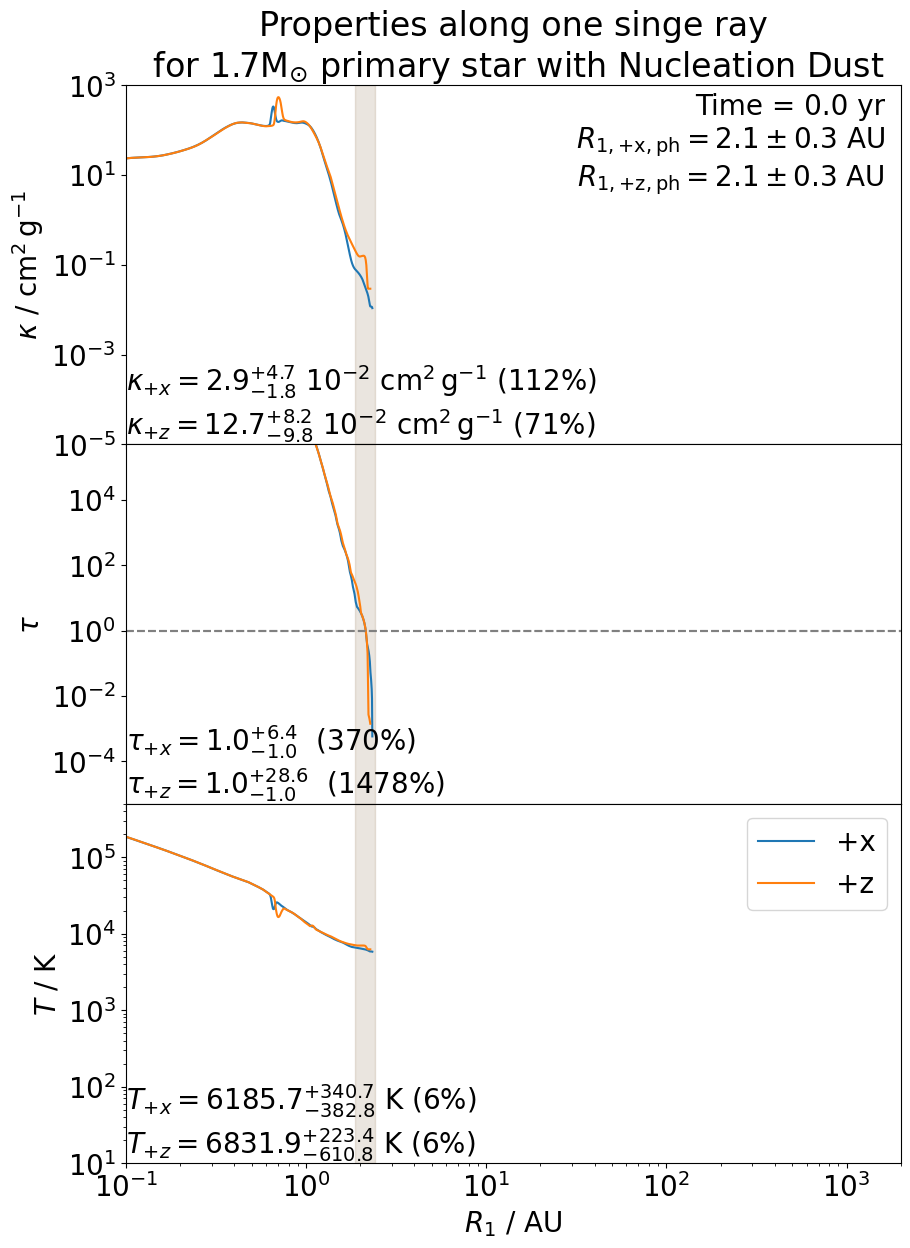


Working on ../photosphere/luis_2md/light_01200__photospherePars__xyz... 

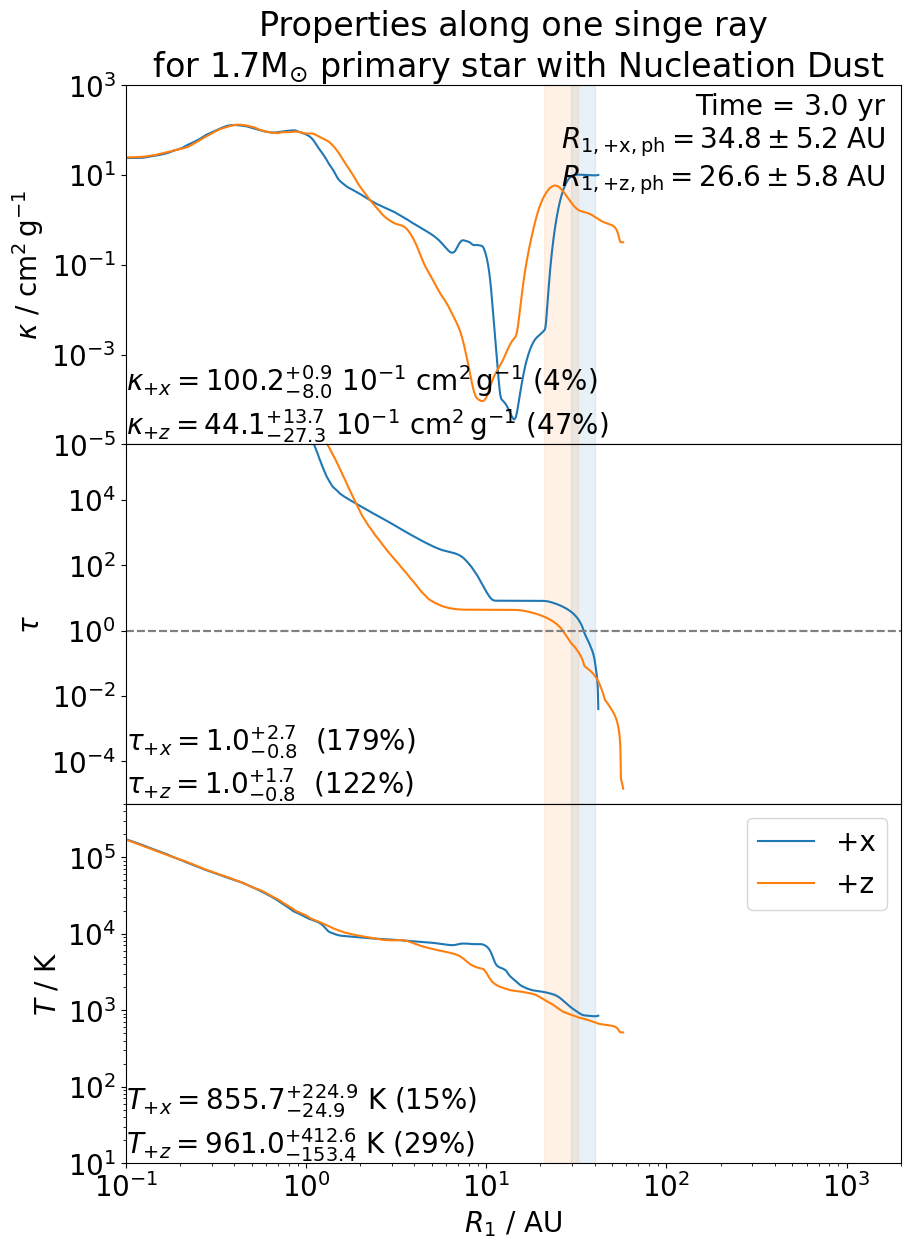


Working on ../photosphere/luis_2md/light_04800__photospherePars__xyz... 

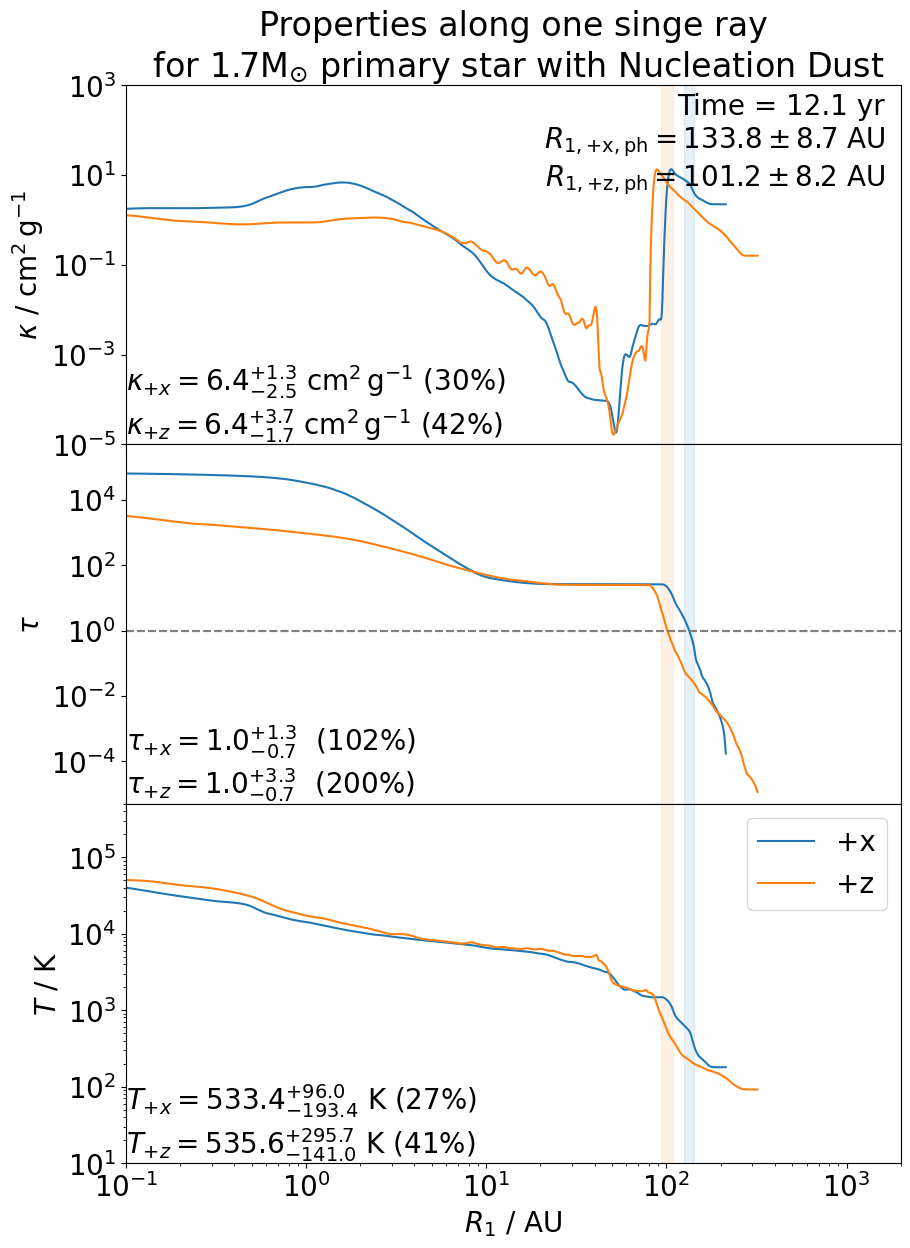


Working on ../photosphere/luis_2md/light_17600__photospherePars__xyz... 

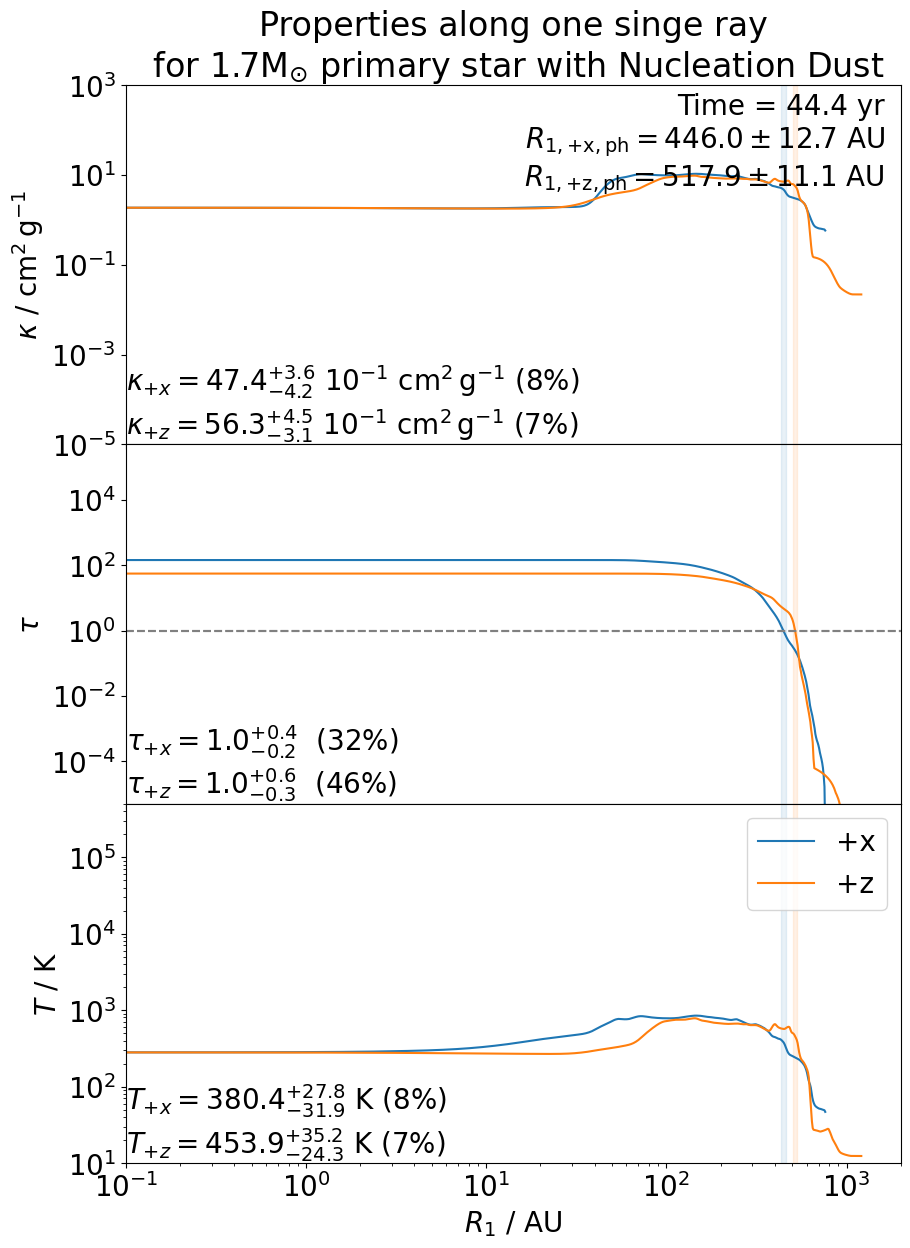

In [11]:
do_debug = True
if do_debug:
    xlim = (1e-1, 2e3)
    job_nicknames = ['2md']
    file_indexes  = [0, 1200, 4800, 17600]
    labels = ['+x', '+z']    # name of the ray to be plotted
    quans  = ['kappa', 'tau', 'T']    # quantities to be plotted
    ylims  = {   # Note: you can supply None
        'tau': (5e-6, 5e5),
        'rho': (5e-20, 5e-6), # None
        'T'  : (1e1, 5e5),
        'kappa': (1e-5, 1e3),
    }
    ylabels = {
        'tau': "\\tau",
        'rho': "\\rho",
        'T'  : "T",
        'kappa': "\\kappa",
    }
    

    # plotting
    for job_nickname in job_nicknames:
        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        outfilenames = []
        for file_index in file_indexes:
            # load data
            jobfilename = mupl.get_filename_phantom_dumps(job_name, file_index)
            outfilename_noext = f"{jobfilename}__photospherePars__xyz"
            if verbose: print(f"\nWorking on {outfilename_noext}... ", end='')
            with open(f"{outfilename_noext}.json", 'r') as f:
                pars_on_ray = json_load(f)
        
            time = set_as_quantity(pars_on_ray['time_yr'], units.yr)
            #orbsep_Rsun = np.array(pars_on_ray['orbsep_Rsun'])

        
            fig, axes = plt.subplots(len(quans), figsize=(10, 2+4*len(quans)), squeeze=False, sharex=True)
            fig.subplots_adjust(hspace=0.0, wspace=0.0)

            xerrs_dict = {}
            for i, label in enumerate(labels):
                photosphere = pars_on_ray['data'][label]
                xval  = get_val_in_unit(photosphere['R1'       ], unitsIn['dist'], unitsOut['dist'])
                xerr  = get_val_in_unit(photosphere['h'        ], unitsIn['dist'], unitsOut['dist'])
                xvals = get_val_in_unit(photosphere['R1_on_ray'], unitsIn['dist'], unitsOut['dist'])
                xerrs_dict[label] = (xval, xerr, xvals)
                
                
            for ax, quan in zip(axes, quans):
                ax = ax[0]
                ylim = ylims[quan] if quan in ylims.keys() else None
                ylabel = ylabels[quan] if quan in ylabels.keys() else None
                unit_name = get_units_field_name(quan)
                valtxts = []
                yvaltxt_logs = []
                yerrs_dict = {}
                
                for i, label in enumerate(labels):
                    photosphere = pars_on_ray['data'][label]
                    xval, xerr, xvals = xerrs_dict[label]
                    xerrp = xval + xerr
                    xerrm = xval - xerr

                    yvals = get_val_in_unit(photosphere[f'{quan}_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                    yval, yerrp, yerrm = get_yval_yerr(xval, xerrp, xerrm, xvals, yvals)
                    dyerrp = yerrp - yval
                    dyerrm = yerrm - yval
                    # store it for later because we want them to be on the same scale for +x and +z
                    yerrs_dict[label] = (yval, dyerrp, dyerrm)
                    
                    ax.loglog(xvals, yvals, color=f'C{i}', label=label)
                    ax.set_xlim(xlim)
                    ax.set_ylim(ylim)
                    ax.fill_betweenx(
                        ax.get_ylim(),
                        get_val_in_unit(photosphere['R1'] - photosphere['h'], unitsIn['dist'], unitsOut['dist']),
                        get_val_in_unit(photosphere['R1'] + photosphere['h'], unitsIn['dist'], unitsOut['dist']),
                        color=f'C{i}', alpha=0.1)
                    ax.set_ylabel(f"${ylabel}$ / {unitsOutTxt[unit_name]}" if unit_name != 'dimless' else f"${ylabel}$")
                    if quan == 'tau':
                        ax.axhline(PHOTOSPHERE_TAU, color='grey', linestyle='dashed')

                    # get the scale of the value for the exact val & err text
                    try:
                        yvaltxt_log = np.log10(np.abs([yval, dyerrm, dyerrp]))
                        yvaltxt_log = int(np.floor(np.average(yvaltxt_log[np.isfinite(yvaltxt_log)])))
                        if quan in ['tau','T']:
                            # mannual override
                            yvaltxt_log = 0
                    except ValueError:
                        yvaltxt_log = 0
                    yvaltxt_logs.append(yvaltxt_log)


                # get val text
                for label in labels:
                    # init
                    yvaltxt_log = min(yvaltxt_logs)
                    yval, dyerrp, dyerrm = yerrs_dict[label]
                    
                    # ignore small scales
                    if yvaltxt_log == 1: yvaltxt_log = 0
                        
                    yvaltxt  = f"${ylabel}_{{{label}}} ="
                    yvaltxt += f"{yval/10**yvaltxt_log:.1f}^{{{dyerrp/10**yvaltxt_log:+.1f}}}_{{{dyerrm/10**yvaltxt_log:+.1f}}}$"
                    if yvaltxt_log != 0: yvaltxt += f" $10^{{{yvaltxt_log}}}$"
                    yvaltxt += f" {unitsOutTxt[unit_name]}"
                    yvaltxt += f" ({(abs(dyerrp)+abs(dyerrm))/yval/2:.0%})"
                    
                    valtxts.append(yvaltxt)
                    
                ax.text(xlim[0], ylim[0], '\n'.join(valtxts), ha='left', va='bottom')
            ax.set_xlabel(f"$R_1$ / {unitsOutTxt['dist']}")
            ax.legend(loc='upper right')

            # set title and time label
            ax = axes[0][0]
            ax_txts = [f"Time = {time:.1f}"]
            for label in labels:
                xval, xerr, _ = xerrs_dict[label]
                ax_txts.append(f"$R_{{1, \\mathrm{{{label}, ph}}}} = {xval:.1f} \\pm {xerr:.1f}$ {unitsOutTxt['dist']}")
            
            ax.text(
                0.98, 0.98,
                '\n'.join(ax_txts),
                color = "black", ha = 'right', va = 'top',
                transform=ax.transAxes,
            )
            ax.set_title(
                f"Properties along one singe ray\n" + \
                #f"resolution = {photospheres['dump_info']['nparttot']:.2e}\n" + \
                f"{job_profile['plot_title_suffix']}",
            )
            # save fig
            outfilename = f"{output_dir}{job_nickname}_{file_index:05d}__singleRayProperties.pdf"
            plt.savefig(outfilename)
            outfilenames.append(outfilename)
            plt.show(fig)

In [70]:
pars_on_ray['data']['+z']['T_on_ray']

array([   653.20543156,    653.20543156,    653.20300044,    653.06404558,
          652.7589476 ,    652.40859762,    652.07565697,    651.7796503 ,
          651.50869986,    651.20770864,    650.84868357,    650.44529141,
          650.01871825,    649.58685897,    649.16231054,    648.75302326,
          648.37153409,    648.15051784,    648.24489134,    648.76269224,
          649.76507123,    651.24878356,    653.16132097,    655.42745269,
          658.00550302,    660.89404715,    664.05916707,    667.44741653,
          670.99999998,    674.66081833,    678.41526953,    682.37252921,
          686.3737649 ,    690.39929129,    694.42611068,    698.43115782,
          702.40203931,    706.32687969,    710.20342025,    714.04956262,
          717.86009538,    721.62212195,    725.32711706,    728.96950915,
          732.54601546,    736.05828478,    739.51289738,    742.91378046,
          746.2638121 ,    749.57041956,    752.85939495,    756.16490726,
          759.51525548,  

In [71]:
rho, T = (
    get_val_in_unit(photosphere[f'{quan}_on_ray'], unitsIn[get_units_field_name(quan)], get_units_cgs(quan))
    for quan in ['rho', 'T']
)
opacs.get_kappa(rho, T)

array([8.34042419e-01, 8.34042419e-01, 8.34041211e-01, 8.33972163e-01,
       8.33820525e-01, 8.33646343e-01, 8.33480764e-01, 8.33333510e-01,
       8.33198685e-01, 8.33048872e-01, 8.32870119e-01, 8.32669205e-01,
       8.32456662e-01, 8.32241399e-01, 8.32029696e-01, 8.31825522e-01,
       8.31635145e-01, 8.31524819e-01, 8.31571930e-01, 8.31830345e-01,
       8.32330239e-01, 8.33069319e-01, 8.34020502e-01, 8.35145354e-01,
       8.36422165e-01, 8.37849146e-01, 8.39408415e-01, 8.41072612e-01,
       8.42812021e-01, 8.44598581e-01, 8.46424725e-01, 8.48342849e-01,
       8.50276055e-01, 8.52214245e-01, 8.54146258e-01, 8.56061136e-01,
       8.57953135e-01, 8.59816842e-01, 8.61702428e-01, 8.63603527e-01,
       8.65481255e-01, 8.67329495e-01, 8.69144336e-01, 8.70923353e-01,
       8.72665252e-01, 8.74371142e-01, 8.76044495e-01, 8.77687462e-01,
       8.79301657e-01, 8.80890861e-01, 8.82467598e-01, 8.84048265e-01,
       8.85646299e-01, 8.87274763e-01, 8.88942521e-01, 8.90655566e-01,
      

In [72]:
T

array([   653.20543156,    653.20543156,    653.20300044,    653.06404558,
          652.7589476 ,    652.40859762,    652.07565697,    651.7796503 ,
          651.50869986,    651.20770864,    650.84868357,    650.44529141,
          650.01871825,    649.58685897,    649.16231054,    648.75302326,
          648.37153409,    648.15051784,    648.24489134,    648.76269224,
          649.76507123,    651.24878356,    653.16132097,    655.42745269,
          658.00550302,    660.89404715,    664.05916707,    667.44741653,
          670.99999998,    674.66081833,    678.41526953,    682.37252921,
          686.3737649 ,    690.39929129,    694.42611068,    698.43115782,
          702.40203931,    706.32687969,    710.20342025,    714.04956262,
          717.86009538,    721.62212195,    725.32711706,    728.96950915,
          732.54601546,    736.05828478,    739.51289738,    742.91378046,
          746.2638121 ,    749.57041956,    752.85939495,    756.16490726,
          759.51525548,  

In [73]:
from lib.clmuphantomlib.settings import DEFAULT_SETTINGS
params = JOB_PROFILES[0]['params']
print(params, '\n', DEFAULT_SETTINGS)
opacs = mupl.eos_mesa.EoS_MESA_opacity(params=params, settings=DEFAULT_SETTINGS)

{'X': 0.691, 'Z': 0.021, 'mu': 2.381} 
 {'PHANTOM_DIR': '/home/clmu/phantom', 'EoS_MESA_DATA_DIR': '/home/clmu/phantom/data/eos/mesa', 'EoS_MESA_table_Z_float': array([0.  , 0.02, 0.04]), 'EoS_MESA_table_Z_str': ['0.00', '0.02', '0.04'], 'EoS_MESA_table_X_float': array([0. , 0.2, 0.4, 0.6, 0.8]), 'EoS_MESA_table_X_str': ['0.00', '0.20', '0.40', '0.60', '0.80'], 'EoS_MESA_table_dtype': [('log10_rho', <class 'numpy.float64'>), ('log10_P', <class 'numpy.float64'>), ('log10_Pgas', <class 'numpy.float64'>), ('log10_T', <class 'numpy.float64'>), ('dlnP/dlnrho|e', <class 'numpy.float64'>), ('dlnP/dlne|rho', <class 'numpy.float64'>), ('dlnT/dlnrho|e', <class 'numpy.float64'>), ('dlnT/dlne|rho', <class 'numpy.float64'>), ('log10_S', <class 'numpy.float64'>), ('dlnT/dlnP|S', <class 'numpy.float64'>), ('Gamma1', <class 'numpy.float64'>), ('gamma', <class 'numpy.float64'>)]}


In [74]:
opacs.get_kappa(rho=1e-17, T=631)

0.8183562910657334

In [28]:
10**opacs._log10_T_arr

array([6.30957344e+02, 6.68343918e+02, 7.07945784e+02, 7.49894209e+02,
       7.94328235e+02, 8.41395142e+02, 8.91250938e+02, 9.44060876e+02,
       1.00000000e+03, 1.05925373e+03, 1.12201845e+03, 1.18850223e+03,
       1.25892541e+03, 1.33352143e+03, 1.41253754e+03, 1.49623566e+03,
       1.58489319e+03, 1.67880402e+03, 1.77827941e+03, 1.88364909e+03,
       1.99526231e+03, 2.11348904e+03, 2.23872114e+03, 2.37137371e+03,
       2.51188643e+03, 2.66072506e+03, 2.81838293e+03, 2.98538262e+03,
       3.16227766e+03, 3.34965439e+03, 3.54813389e+03, 3.75837404e+03,
       3.98107171e+03, 4.21696503e+03, 4.46683592e+03, 4.73151259e+03,
       5.01187234e+03, 5.30884444e+03, 5.62341325e+03, 5.95662144e+03,
       6.30957344e+03, 6.68343918e+03, 7.07945784e+03, 7.49894209e+03,
       7.94328235e+03, 8.41395142e+03, 8.91250938e+03, 9.44060876e+03,
       1.00000000e+04, 1.05925373e+04, 1.12201845e+04, 1.18850223e+04,
       1.25892541e+04, 1.33352143e+04, 1.41253754e+04, 1.49623566e+04,
      

In [16]:
# properties evolution with time plots

if __name__ == '__main__':

    # settings
    xlim = (0., 15.)
    labels = ['+x', '+z']    # name of the ray to be plotted
    quans  = ['T', 'rho', 'tau', 'kappa']    # quantities to be plotted
    ylims  = {   # Note: you can supply None
        'tau': (1e-2, 1e2),
        'rho': (1e-18, 1e-8), # None
        'T'  : (1e2, 5e4), #(1e2, 1e3),
        'kappa': None,
    }
    ylabels = {
        'tau': "\\tau",
        'rho': "\\rho",
        'T'  : "T",
        'kappa': "\\kappa",
    }
    

    # plotting
    for job_profile in JOB_PROFILES:
        job_name    = job_profile['job_name']
        outfilenames = []
        times  = []
        orbseps= []
        # quans_dict[quan][ax] = (vals, dyerrps, dyerrms)
        quans_dict = { quan: {label: ([], [], []) for label in labels} for quan in quans }
        for file_index in job_profile['file_indexes']:
            # load data
            jobfilename = mupl.get_filename_phantom_dumps(job_name, file_index)
            outfilename_noext = f"{jobfilename}__photospherePars__xyz"
            #if verbose: print(f"\nWorking on {outfilename_noext}... ", end='')
            with open(f"{outfilename_noext}.json", 'r') as f:
                pars_on_ray = json_load(f)
        
            times.append(  get_val_in_unit(pars_on_ray['time_yr'    ], units.yr,   unitsOut['time']))
            orbseps.append(get_val_in_unit(pars_on_ray['orbsep_Rsun'], units.Rsun, unitsOut['dist']))

            xerrs_dict = {}
            for i, label in enumerate(labels):
                photosphere = pars_on_ray['data'][label]
                xval  = get_val_in_unit(photosphere['R1'       ], unitsIn['dist'], unitsOut['dist'])
                xerr  = get_val_in_unit(photosphere['h'        ], unitsIn['dist'], unitsOut['dist'])
                xvals = get_val_in_unit(photosphere['R1_on_ray'], unitsIn['dist'], unitsOut['dist'])
                xerrs_dict[label] = (xval, xerr, xvals)
                
                
            for quan in quans:
                valtxts = []
                yerrs_dict = {}
                unit_name = get_units_field_name(quan)
                for i, label in enumerate(labels):
                    photosphere = pars_on_ray['data'][label]
                    xval, xerr, xvals = xerrs_dict[label]
                    xerrp = xval + xerr
                    xerrm = xval - xerr
                    yvals = get_val_in_unit(photosphere[f'{quan}_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                    yval, yerrp, yerrm = get_yval_yerr(xval, xerrp, xerrm, xvals, yvals)
                    dyerrp = yerrp - yval
                    dyerrm = yerrm - yval
                    quans_dict[quan][label][0].append(yval)
                    quans_dict[quan][label][1].append(dyerrp)
                    quans_dict[quan][label][2].append(dyerrm)

        times   = np.array(times)
        orbseps = np.array(orbseps)
        # plotting
        for quan in quans:
            unit_name = get_units_field_name(quan)
            ylabel = ylabels[quan]
            fig, ax = plt.subplots(figsize=(10, 8))
            fig.subplots_adjust(left=0.15, top=0.8)
            ax.set_title(
                f"Evolution of photospheric ${ylabel}$ for one singe ray\n" + \
                #f"resolution = {photospheres['dump_info']['nparttot']:.2e}\n" + \
                f"{job_profile['plot_title_suffix']}",
            )


            for i, label in enumerate(labels):
                x = times
                y      = np.array(quans_dict[quan][label][0])
                dyerrp = np.array(quans_dict[quan][label][1])
                dyerrm = np.array(quans_dict[quan][label][2])
                ax.semilogy(x, y, '-', color=f'C{i}', label=label)    
                ax.fill_between(x, y+dyerrp, y+dyerrm, color=f'C{i}', alpha=0.15)

            ax.set_xlim(xlim)
            ax.set_ylim(ylims[quan])
            ax.set_xlabel("Time / year")
            ax.set_ylabel(f"${ylabel}$ / {unitsOutTxt[unit_name]}" if unit_name != 'dimless' else f"${ylabel}$")
            ax.legend(loc='lower left')


            # getting funcs for 2nd x axis transform, and
            # making sure orbseps is mono-decreasing, so np.interp doesn't freak out
            orbsep_tempmin = orbseps[0]
            x_inds = [0]
            for i in range(len(orbseps)):
                if orbsep_tempmin > orbseps[i]:
                    orbsep_tempmin = orbseps[i]
                    x_inds.append(i)
            times_inds   = times[x_inds].copy()
            orbseps_inds = orbseps[x_inds].copy()
            if xlim[1] > times_inds[-1]:
                # add an end point so the secondary xaxis labels of orbsep does not freak out
                times_inds   = np.append(times_inds, xlim[1])
                orbseps_inds = np.append(orbseps_inds, orbseps_inds[-1]*(1.-1e-5))
            functions = (
                lambda x: np.interp(x, times_inds, orbseps_inds),
                lambda x: np.interp(x, orbseps_inds[::-1], times_inds[::-1]),
            )
            secax = ax.secondary_xaxis('top', functions=functions)
            secax.set_xlabel(f"Separation (Dusty) / {unitsOutTxt['dist']}")
            secax.set_ticks(functions[0](ax.get_xticks()[:-1]))
            
            # save fig
            # define job_folder_prefix
            for i in range(len(job_name)-1, -1, -1):
                if job_name[i] == path.sep:
                    job_folder_prefix = job_name[:i]
                    break
                else:
                    job_folder_prefix = job_name
            outfilename = f"{job_folder_prefix}__singleRayEvo-{quan}.png"
            fig.savefig(outfilename)
            plt.close(fig)

    if verbose: print("\n\n\n*** All Done. ***\n\n\n")




*** All Done. ***





In [21]:
# properties error percentage evolution with time plots

if __name__ == '__main__':

    # settings
    xlim = (0., 44.)
    labels = ['+x', '+z']    # name of the ray to be plotted
    quans  = ['T', 'rho', 'tau']    # quantities to be plotted
    ylims  = {   # Note: you can supply None
        'tau': (0, 300),
        'rho': (0, 500), # None
        'T'  : (0, 100),
    }
    ylabels = {
        'tau': "\\tau",
        'rho': "\\rho",
        'T'  : "T",
    }
    

    # plotting
    for job_profile in JOB_PROFILES:
        job_name    = job_profile['job_name']
        outfilenames = []
        times  = []
        orbseps= []
        # quans_dict[quan][ax] = (vals, dyerrps, dyerrms)
        quans_dict = { quan: {label: ([], [], []) for label in labels} for quan in quans }
        for file_index in job_profile['file_indexes']:
            # load data
            jobfilename = mupl.get_filename_phantom_dumps(job_name, file_index)
            outfilename_noext = f"{jobfilename}__photospherePars__xyz"
            #if verbose: print(f"\nWorking on {outfilename_noext}... ", end='')
            with open(f"{outfilename_noext}.json", 'r') as f:
                pars_on_ray = json_load(f)
        
            times.append(get_val_in_unit(pars_on_ray['time_yr'], units.yr, unitsOut['time']))
            orbseps.append(get_val_in_unit(pars_on_ray['orbsep_Rsun'], units.Rsun, unitsOut['dist']))

            xerrs_dict = {}
            for i, label in enumerate(labels):
                photosphere = pars_on_ray['data'][label]
                xval  = get_val_in_unit(photosphere['R1'       ], unitsIn['dist'], unitsOut['dist'])
                xerr  = get_val_in_unit(photosphere['h'        ], unitsIn['dist'], unitsOut['dist'])
                xvals = get_val_in_unit(photosphere['R1_on_ray'], unitsIn['dist'], unitsOut['dist'])
                xerrs_dict[label] = (xval, xerr, xvals)
                
                
            for quan in quans:
                valtxts = []
                yerrs_dict = {}
                for i, label in enumerate(labels):
                    photosphere = pars_on_ray['data'][label]
                    xval, xerr, xvals = xerrs_dict[label]
                    xerrp = xval + xerr
                    xerrm = xval - xerr

                    yvals = get_val_in_unit(photosphere[f'{quan}_on_ray'], unitsIn[unit_name], unitsOut[unit_name])
                    yval, yerrp, yerrm = get_yval_yerr(xval, xerrp, xerrm, xvals, yvals)
                    dyerrp = yerrp - yval
                    dyerrm = yerrm - yval
                    quans_dict[quan][label][0].append(yval)
                    quans_dict[quan][label][1].append(dyerrp)
                    quans_dict[quan][label][2].append(dyerrm)

        times   = np.array(times)
        orbseps = np.array(orbseps)
        # plotting
        for quan in quans:
            unit_name = get_units_field_name(quan)
            ylabel = ylabels[quan]
            fig, ax = plt.subplots(figsize=(10, 8))
            fig.subplots_adjust(left=0.15, top=0.8)
            ax.set_title(
                f"Relative uncetainty on photospheric ${ylabel}$ at one singe ray\n" + \
                #f"resolution = {photospheres['dump_info']['nparttot']:.2e}\n" + \
                f"{job_profile['plot_title_suffix']}",
            )


            for i, label in enumerate(labels):
                x = times
                yvals  = np.array(quans_dict[quan][label][0])
                dyerrp = np.array(quans_dict[quan][label][1])
                dyerrm = np.array(quans_dict[quan][label][2])
                y = (np.abs(dyerrp)+np.abs(dyerrm)) / np.abs(yvals) / 2
                ax.scatter(x, y*100, color=f'C{i}', label=label)

            ax.set_xlim(xlim)
            ax.set_ylim(ylims[quan])
            ax.set_xlabel("Time / year")
            ax.set_ylabel(f"$ \\Delta {ylabel} / {ylabel}$ / $\\%$")
            ax.legend(loc='upper right')


            # getting funcs for 2nd x axis transform, and
            # making sure orbseps is mono-decreasing, so np.interp doesn't freak out
            orbsep_tempmin = orbseps[0]
            x_inds = [0]
            for i in range(len(orbseps)):
                if orbsep_tempmin > orbseps[i]:
                    orbsep_tempmin = orbseps[i]
                    x_inds.append(i)
            times_inds   = times[x_inds].copy()
            orbseps_inds = orbseps[x_inds].copy()
            if xlim[1] > times_inds[-1]:
                # add an end point so the secondary xaxis labels of orbsep does not freak out
                times_inds   = np.append(times_inds, xlim[1])
                orbseps_inds = np.append(orbseps_inds, orbseps_inds[-1]*(1.-1e-5))
            functions = (
                lambda x: np.interp(x, times_inds, orbseps_inds),
                lambda x: np.interp(x, orbseps_inds[::-1], times_inds[::-1]),
            )
            secax = ax.secondary_xaxis('top', functions=functions)
            secax.set_xlabel(f"Separation (Dusty) / {unitsOutTxt['dist']}")
            secax.set_ticks(functions[0](ax.get_xticks()[:-1]))
            
            # save fig
            # define job_folder_prefix
            for i in range(len(job_name)-1, -1, -1):
                if job_name[i] == path.sep:
                    job_folder_prefix = job_name[:i]
                    break
                else:
                    job_folder_prefix = job_name
            outfilename = f"{job_folder_prefix}__singleRayErrPct-{quan}.png"
            fig.savefig(outfilename)
            plt.close(fig)

    if verbose: print("\n\n\n*** All Done. ***\n\n\n")




*** All Done. ***





In [111]:
1.06**4

1.2624769600000003